# Linear operator as a sum of Pauli strings

Every linear operator in quantum mechanics can be expressed as a sum of Pauli strings considering every combination possible restricted to the dimension of our problem.

$$
O=\sum_{P\in P_m}c_P P
$$

In this code we'll calculate the coefficients corresponding with each Pauli string for a generic operator O and do an histogram to observe the size distribution of the operators.

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate ,PauliGate
from qiskit.synthesis import MatrixExponential,LieTrotter
from qiskit.quantum_info.operators import Operator
from qiskit.primitives import Estimator, StatevectorEstimator, Sampler
from collections import Counter




from scipy.linalg import expm




In [117]:
np.random.seed(1)  # seed to reproduce h samplings
N=12
np.random.rand(N)*0.2

array([8.34044009e-02, 1.44064899e-01, 2.28749635e-05, 6.04665145e-02,
       2.93511782e-02, 1.84677190e-02, 3.72520423e-02, 6.91121454e-02,
       7.93534948e-02, 1.07763347e-01, 8.38389029e-02, 1.37043900e-01])

## Functions and parameters

In [35]:
#Hamiltonian
def BKP(N,b,J,h_random):
    
    h=h_random
    #Hamiltonian
    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]  
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_hopping = ['I'*i + 'ZZ' + 'I'*(N-2-i) for i in range(N-1)]

    H_K=sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_X])
    H_I=(sum([SparsePauliOp.from_list([(term, h[terms_site_Z.index(term)])]) for term in terms_site_Z]) + sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])).simplify()

    # Pasamos los hamiltonianos a matrices
    H_K_matrix = H_K.to_matrix()
    H_I_matrix = H_I.to_matrix()

    # Hacemos el operador de evolución temporal de un paso
    U_K = expm(-1j * H_K_matrix)
    U_I = expm(-1j * H_I_matrix)

    U = U_K@U_I
    U_dag = np.conj(U).T


    return U, U_dag


def H_transverse_Ising(N,b,J,h):
    # In order to define the hamiltonian we first want to create lists with all the possible combinations
    terms_hopping = ['I'*i + 'XX' + 'I'*(N-2-i) for i in range(N-1)]
    terms_site_Z  = ['I'*i + 'Z' + 'I'*(N-1-i) for i in range(N)]
    terms_site_X  = ['I'*i + 'X' + 'I'*(N-1-i) for i in range(N)]

    H_hopping=sum([SparsePauliOp.from_list([(term, J)]) for term in terms_hopping])
    H_site_Z = sum([SparsePauliOp.from_list([(term, b)]) for term in terms_site_Z])
    H_site_X = sum([SparsePauliOp.from_list([(term, h)]) for term in terms_site_X])


    H=H_hopping  + H_site_Z + H_site_X 
    # Pasamos los hamiltonianos a matrices
    H_matrix = H.to_matrix()

    return H_matrix


## Trace

Now we are going to perform the same calculation but with another method. Instead of calculating the coefficients via a circuit we are going to calculate them analtically with the trace of the operator multplied by the string. 
$$(c_P)= \frac{1}{2^N}tr(O P)$$

Since we do not have an actual quantum computer, if we want to rise the number of qubits (N) we'll need to simulate the circuit.

In [46]:
def op_to_pauli(time, V, N, b, J, h_random):
    # Hamiltonian
    U, U_dag = BKP(N, b, J, h_random)
    V_t = V.to_matrix()
    q_i = [[[] for _ in range(N+1)] for i in range(time)] # q_i[time][size][coefficients]

    q_t = []
    Q_t = []

    sizes=[]

    for t in range(time):
        print(t)
        O_t_pauli = SparsePauliOp.from_operator(Operator(V_t)).simplify() # Descomposición en Paulis (Juan)
        V_t = U_dag@V_t@U


        q = np.zeros((N+1), dtype = complex)
        Q = np.zeros(N+1)   

        l=[]

    #get the sizes
        for label, coeff in O_t_pauli.to_list():
            size = sum(1 for char in label if char != 'I')
            q_i[t][size].append(coeff) #Insert the elements. q_i[time][size][coefficients]
            #print(label, coeff, size)
            q[size] += coeff**2  # winding size distribution
            Q[size] += np.abs(coeff)**2 # size distribution
            l.append(size)
        q_t.append(q)
        Q_t.append(Q)

        sizes.append(l)     

    return q_i,q_t, Q_t, sizes

def op_to_pauli_trans(time, V, N, b, J, h,paso):
    # Hamiltonian
    times=np.arange(0,time,paso)

    H = H_transverse_Ising(N,b,J,h)
    V_matrix = V.to_matrix()
    q_i = [[[] for _ in range(N+1)] for i in range(len(times))] # q_i[time][size][coefficients]

    q_t = []
    Q_t = []


    for index, t in enumerate(times):
        # Evolucionamos operadores
        U = expm(-1j *t* H)
        U_dag = np.conj(U).T
        V_t = U_dag@V_matrix@U

        print(t)
        O_t_pauli = SparsePauliOp.from_operator(Operator(V_t)).simplify() # Descomposición en Paulis (Juan)
        

        q = np.zeros((N+1), dtype = complex)
        Q = np.zeros(N+1)

    #get the sizes
        for label, coeff in O_t_pauli.to_list():
            size = sum(1 for char in label if char != 'I')
            q_i[index][size].append(coeff) #Insert the elements. q_i[time][size][coefficients]
            #print(label, coeff, size)
            q[size] += coeff**2  # winding size distribution
            Q[size] += np.abs(coeff)**2 # size distribution
        q_t.append(q)
        Q_t.append(Q)

                    

    return q_i,q_t, Q_t 


def op_to_pauli_exp(time, V, N, b, J, h_random):
    # Hamiltonian
    U, U_dag = BKP(N, b, J, h_random)
    q_i = [[[] for _ in range(N+1)] for i in range(time)] # q_i[time][size][coefficients]

    q_t = []
    Q_t = []
    V_t=V
  
    for t in range(time):
        print(t)
        O_t_pauli = SparsePauliOp.from_operator(Operator(V_t)).simplify() # Descomposición en Paulis (Juan)
        V_t = U_dag@V_t@U


        q = np.zeros((N+1), dtype = complex)
        Q = np.zeros(N+1)   
    #get the sizes
        for label, coeff in O_t_pauli.to_list():
            size = sum(1 for char in label if char != 'I')
            q_i[t][size].append(coeff) #Insert the elements. q_i[time][size][coefficients]
            #print(label, coeff, size)
            q[size] += coeff**2  # winding size distribution
            Q[size] += np.abs(coeff)**2 # size distribution
        q_t.append(q)
        Q_t.append(Q)
                    

    return q_i,q_t, Q_t #, l_times_tr,


In [109]:
# Now we define the plots

def plots(time,Q_t,condition,coefs, paso): #Condition: True if we want to plot the angles (Non-Hermitian V matrix)
    #Comprobamos que la suma de los coeficientes sea 1
    q_mod_sum=[]
    for t in range(time):
        print(f'Time {t+1}: {sum(Q_t[t])}')
        q_mod_sum.append(sum(Q_t[t]))

    # Plot the sum of the coefficientsvs time
    plt.figure(1)
    for n in range(N+1):
        q_temp = [Q_t[t][n] for t in range(time)]
        plt.plot(range(time), q_temp, label=f'Tamaño {n}') #sum of the coefficients squared for each length
    plt.plot(range(time), q_mod_sum, 'k--', label='Total sum')# Total sum 
    plt.axvline(x=8, color='red', linestyle='--',label='t=8',alpha=0.5)
    plt.xlabel('Tiempo')
    plt.ylabel(r'$Q_O(l)$')
    plt.title('Suma de los coeficientes frente a tiempo')
    plt.legend(loc='upper right',ncol=2)
    plt.grid(True)
    plt.savefig(f'sizes time={time} este meu n={N} bkp={Q_t[-1][-1]}.pdf',dpi=400)
    plt.show()
    


    if condition:
        #We are going to get the angles of each coefficient
        angle=[] #angle[time][size]
        angles_promediate = []
        for t in range(time):
            angles_t=[]
            for n in range(N+1):
                angles_tt=[]
                for i in range(len(coefs[t][n])):
                    if np.abs(coefs[t][n][i])>1e-2:#criba de los coeficientes que mas contribuyen
                        angles = np.angle(coefs[t][n][i])  # This is in radians by default, range [-pi, pi]
                        angles = np.where(angles < 0, angles + 2*np.pi, angles) # Adjust range to [0, 2pi]
                        angles=float(angles)
                        angles_tt.append(angles)
                #Promedio angulos para cada tamaño ya que deberían ser iguales
                if len(angles_tt) <= paso: # Evito errores de división por 0
                    average = [sum(angles_tt) / len(angles_tt)] if angles_tt else []
                else: 
                    variable = 0
                    average = []
                    while variable < len(angles_tt) - paso:
                        l = sum(angles_tt[variable:(variable + paso)]) / paso #promedio
                        variable += paso
                        average.append(l)
                    
                    # Handling remaining elements
                    if variable < len(angles_tt):
                        remaining_average = sum(angles_tt[variable:]) / len(angles_tt[variable:])
                        average.append(remaining_average)
                
                angles_t.append(average)
            angle.append(angles_t)

            #plots

        for times_ang in range(time):

            # Prepare the plot
            plt.figure((times_ang+2),figsize=(10, 6))

            # Lists to store the averages and their corresponding size values
            average_angles = []
            size_values_for_averages = []

            # Generate x values for each size, ensuring they are separated into N+1 parts
            x_values = np.arange(N+1)

            # For each size, plot the angles at the fixed time step
            for n in range(N+1):
                angles_at_n = angle[times_ang][n]  # This gets the angles for size n at time t_fixed
                y_values = angles_at_n  # The angles to be plotted
                
                # Calculate the average angle for the current size
                average_angle = np.mean(y_values)
                average_angles.append(average_angle)
                size_values_for_averages.append(n)
                
                # Adjust the spread calculation to center the dots around their size
                num_dots = len(y_values)
                max_spread = 0.5  # Maximum spread allowed on either side of the center
                if num_dots > 1:
                    spacing_factor = max_spread / (num_dots - 1)  # Adjust spacing factor based on number of dots
                else:
                    spacing_factor = 0  # No spread needed for a single dot

                # Center the spread around the size value, ensuring it stays within the vertical lines
                x_spread = [n + ((i - (num_dots - 1) / 2) * spacing_factor) for i in range(num_dots)]
                
                # Scatter plot for each size with an ordered spread on the x-axis
                plt.scatter(x_spread, y_values, label=f'Size {n}')

                # Draw vertical lines to separate different sizes
                if n < N:  # Avoid drawing a line after the last size
                    plt.axvline(x=n + 0.5, color='grey', linestyle='--')

            # Plot the line connecting the averages
            # plt.plot(size_values_for_averages, average_angles, color='k', marker='o', linestyle='-', linewidth=2, markersize=5, label='Ángulo')
            plt.axhline(y=np.pi, color='r', linestyle='--',label='pi',alpha=0.5)
            plt.axhline(y=2*np.pi, color='r', linestyle='--',label='2*pi',alpha=0.5)
            plt.title(f'Ángulos para cada tamaño en t={times_ang}')
            plt.xlabel('Tamaño')
            plt.ylabel('Ángulo')
            plt.xticks(x_values)  # Set x-ticks to clearly show each size
            plt.legend(loc='upper right')
            plt.show()


def plots_trans(time,paso,Q_t,condition,coefs, rebinning):
    times=np.arange(0,time,paso)
    #Comprobamos que la suma de los coeficientes sea 1
    q_mod_sum=[]
    for i,t in enumerate(times):
        print(f'Time {t}: {sum(Q_t[i])}')
        q_mod_sum.append(sum(Q_t[i]))

    # Plot the sum of the coefficientsvs time
    plt.figure(1)
    for n in range(N+1):
        q_temp = [Q_t[i][n] for i,t in enumerate(times)]
        plt.plot(times, q_temp, label=f'Size {n}') #sum of the coefficients squared for each length
    plt.plot(times, q_mod_sum, 'k--', label='Total sum')# Total sum 
    plt.xlabel('Time')
    plt.ylabel('Sum of coefficients')
    plt.title('Sum of coefficients vs Time')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    if condition:
        #We are going to get the angles of each coefficient
        angle=[] #angle[time][size]
        angles_promediate = []
        for t,_ in enumerate(times):
            angles_t=[]
            for n in range(N+1):
                angles_tt=[]
                for i in range(len(coefs[t][n])):
                    if np.abs(coefs[t][n][i])>1e-2:
                        angles = np.angle(coefs[t][n][i])  # This is in radians by default, range [-pi, pi]
                        angles = np.where(angles < 0, angles + 2*np.pi, angles) # Adjust range to [0, 2pi]
                        angles=float(angles)
                        angles_tt.append(angles)

                if len(angles_tt) <= rebinning:
                    average = [sum(angles_tt) / len(angles_tt)] if angles_tt else []
                else: 
                    variable = 0
                    average = []
                    while variable < len(angles_tt) - rebinning:
                        l = sum(angles_tt[variable:(variable + rebinning)]) / rebinning
                        variable += rebinning
                        average.append(l)
                    
                    # Handling remaining elements
                    if variable < len(angles_tt):
                        remaining_average = sum(angles_tt[variable:]) / len(angles_tt[variable:])
                        average.append(remaining_average)
                
                angles_t.append(average)
            angle.append(angles_t)

        for times_ang,_ in enumerate(times):

            # Prepare the plot
            plt.figure((times_ang+2),figsize=(10, 6))

            # Lists to store the averages and their corresponding size values
            average_angles = []
            size_values_for_averages = []

            # Generate x values for each size, ensuring they are separated into N+1 parts
            x_values = np.arange(N+1)

            # For each size, plot the angles at the fixed time step
            for n in range(N+1):
                angles_at_n = angle[times_ang][n]  # This gets the angles for size n at time t_fixed
                y_values = angles_at_n  # The angles to be plotted
                
                # Calculate the average angle for the current size
                average_angle = np.mean(y_values)
                average_angles.append(average_angle)
                size_values_for_averages.append(n)
                
                # Adjust the spread calculation to center the dots around their size
                num_dots = len(y_values)
                max_spread = 0.5  # Maximum spread allowed on either side of the center
                if num_dots > 1:
                    spacing_factor = max_spread / (num_dots - 1)  # Adjust spacing factor based on number of dots
                else:
                    spacing_factor = 0  # No spread needed for a single dot

                # Center the spread around the size value, ensuring it stays within the vertical lines
                x_spread = [n + ((i - (num_dots - 1) / 2) * spacing_factor) for i in range(num_dots)]
                
                # Scatter plot for each size with an ordered spread on the x-axis
                plt.scatter(x_spread, y_values, label=f'Size {n}')

                # Draw vertical lines to separate different sizes
                if n < N:  # Avoid drawing a line after the last size
                    plt.axvline(x=n + 0.5, color='grey', linestyle='--')

            # Plot the line connecting the averages
            plt.plot(size_values_for_averages, average_angles, color='k', marker='o', linestyle='-', linewidth=2, markersize=5, label='Average Angle')

            plt.title(f'Angles by Size at Time Step {times_ang}')
            plt.xlabel('Size')
            plt.ylabel('Angle Value')
            plt.xticks(x_values)  # Set x-ticks to clearly show each size
            plt.legend()
            plt.show()


In [47]:
def plot_hist(size, Q, time):

    plt.figure(int(time+1))
    plt.bar(size, Q, color='skyblue', width=0.8)
    plt.xlabel('Tamaños', fontsize=12)
    plt.ylabel(r'$q_O(l)$', fontsize=12)
    plt.title('Operator size at t=%g' % (time), fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(f'histograma t={time}.pdf',dpi=400)
    plt.show()

## Test

### N=3, comprobación

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
Time 1: 1.0
Time 2: 1.0000000000000002
Time 3: 0.9999999999422993
Time 4: 0.9999999999736211
Time 5: 0.9999999999478832
Time 6: 0.9999999999800804
Time 7: 0.9999999999735583
Time 8: 0.9999999999999927
Time 9: 1.0000000000000022
Time 10: 1.0000000000000027
Time 11: 1.0000000000000029
Time 12: 1.0000000000000029
Time 13: 1.0000000000000033
Time 14: 1.000000000000004
Time 15: 1.0000000000000038
Time 16: 1.0000000000000042
Time 17: 1.0000000000000044
Time 18: 1.0000000000000047
Time 19: 1.0000000000000049
Time 20: 1.000000000000005
Time 21: 1.0000000000000056
Time 22: 1.0000000000000056
Time 23: 1.000000000000006
Time 24: 1.000000000000006
Time 25: 1.0000000000000064
Time 26: 1.0000000000000069
Time 27: 1.000000000000007
Time 28: 1.0000000000000073
Time 29: 1.0000000000000075
Time 30: 1.0000000000000075
Time 31: 1.0000000000000082
Time 3

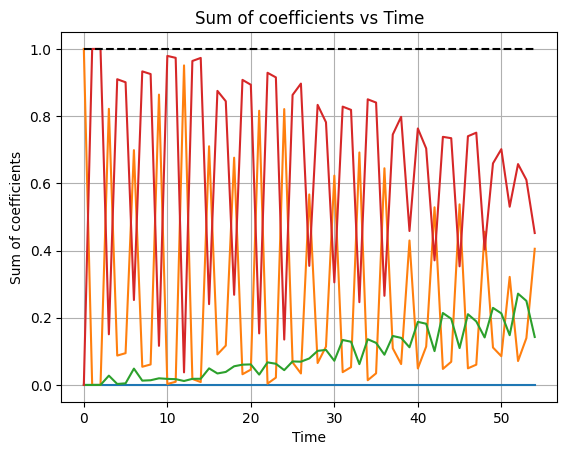

In [9]:
N=3
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])
h=np.array([0.01044837, 0.05760976, 0.07093719])

time=55
q_i, q, Q,sizes = op_to_pauli(time, V, N, b=np.pi/4, J=np.pi/4, h_random=h)

plots(time,Q,condition=False, coefs=q_i, paso=1)

### BKP*, N=12, h=0.2, V='IX'+'I'*(N-2)

In [5]:
N=12
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])
h=np.array([8.34044009e-02, 1.44064899e-01, 2.28749635e-05, 6.04665145e-02,2.93511782e-02, 1.84677190e-02, 3.72520423e-02, 6.91121454e-02,7.93534948e-02, 1.07763347e-01, 8.38389029e-02, 1.37043900e-01])

time=55
q_i, q, Q ,sizes= op_to_pauli(time, V, N, b=np.pi/4, J=np.pi/4, h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54


#### Plots

Time 1: 1.0
Time 2: 1.0000000000000053
Time 3: 0.999999999942309
Time 4: 0.9999999999132616
Time 5: 0.9999999997331055
Time 6: 0.9999999956313333
Time 7: 0.9999999776304205
Time 8: 0.9999998965700677
Time 9: 0.9999995948586022
Time 10: 0.9999985246274827
Time 11: 0.9999947386867463
Time 12: 0.9999820939129564
Time 13: 0.999961282359098
Time 14: 0.9999325930842897
Time 15: 0.9999049387051211
Time 16: 0.9998799051022796
Time 17: 0.9998568925849572
Time 18: 0.9998387131533207
Time 19: 0.9998228151385387
Time 20: 0.9998127870996553
Time 21: 0.9998075395223552
Time 22: 0.9998077628138955
Time 23: 0.9998125494208068
Time 24: 0.9998205782932664
Time 25: 0.9998299969546948
Time 26: 0.9998410677232135
Time 27: 0.9998523403950086
Time 28: 0.9998636710043932
Time 29: 0.9998753344909808
Time 30: 0.9998864558870624
Time 31: 0.9998960767963696
Time 32: 0.9999046841538023
Time 33: 0.9999119304976805
Time 34: 0.9999179601081197
Time 35: 0.9999231514679456
Time 36: 0.9999270638203493
Time 37: 0.9999305

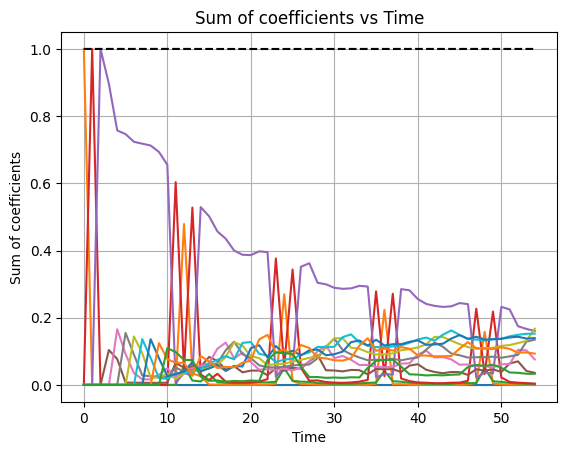

In [11]:
plots(time,Q,condition=False, coefs=q_i, paso=1)

### BKP* N=10, V='IH'+'I'*(N-2)

In [29]:
N=10
h=np.array([8.34044009e-02, 1.44064899e-01, 2.28749635e-05, 6.04665145e-02,
       2.93511782e-02, 1.84677190e-02, 3.72520423e-02, 6.91121454e-02,
       7.93534948e-02, 1.07763347e-01])
X1=Operator(PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0]))
X2=Operator(PauliGate(['I'*(i-1) + 'Z' + 'I'*(N-i) for i in [int(N/2)]][0]))


V=1/np.sqrt(2)*(X1+1j*X2)

time=50
q_i,q, Q,sizes = op_to_pauli(time, V, N, b=np.pi/4, J=np.pi/4, h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


#### Plot

Time 1: 0.9999999999999998
Time 2: 1.0000000000000002
Time 3: 0.9999999999999998
Time 4: 0.9999999999999994
Time 5: 0.9999999959936725
Time 6: 0.9999999231693629
Time 7: 0.9999993206984923
Time 8: 0.9999974829261606
Time 9: 0.9999936808952246
Time 10: 0.9999921391474937
Time 11: 0.9999956782586101
Time 12: 0.9999984527248615
Time 13: 0.9999993982770768
Time 14: 0.9999997348502911
Time 15: 0.9999998481375898
Time 16: 0.9999999108302986
Time 17: 0.9999999345440062
Time 18: 0.9999999517336733
Time 19: 0.9999999622546071
Time 20: 0.999999971084423
Time 21: 0.9999999755009925
Time 22: 0.9999999788968594
Time 23: 0.9999999827160215
Time 24: 0.999999984549943
Time 25: 0.9999999867005138
Time 26: 0.9999999895767835
Time 27: 0.9999999887822771
Time 28: 0.9999999900845623
Time 29: 0.9999999902969856
Time 30: 0.9999999906184782
Time 31: 0.9999999905960185
Time 32: 0.9999999899863207
Time 33: 0.9999999908351431
Time 34: 0.9999999925239743
Time 35: 0.9999999902960404
Time 36: 0.9999999914574571
Tim

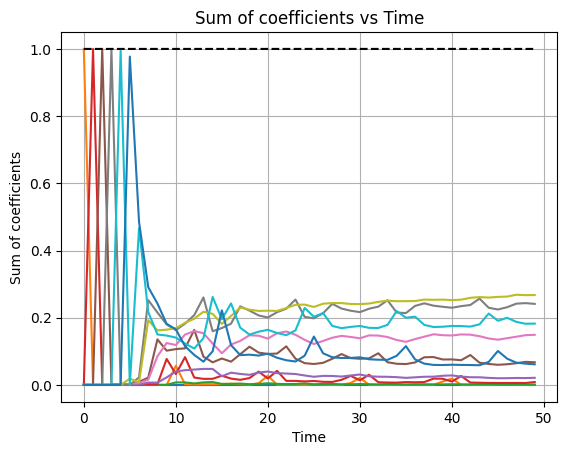

c:\Users\manue\anaconda3\envs\qutip\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\manue\anaconda3\envs\qutip\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


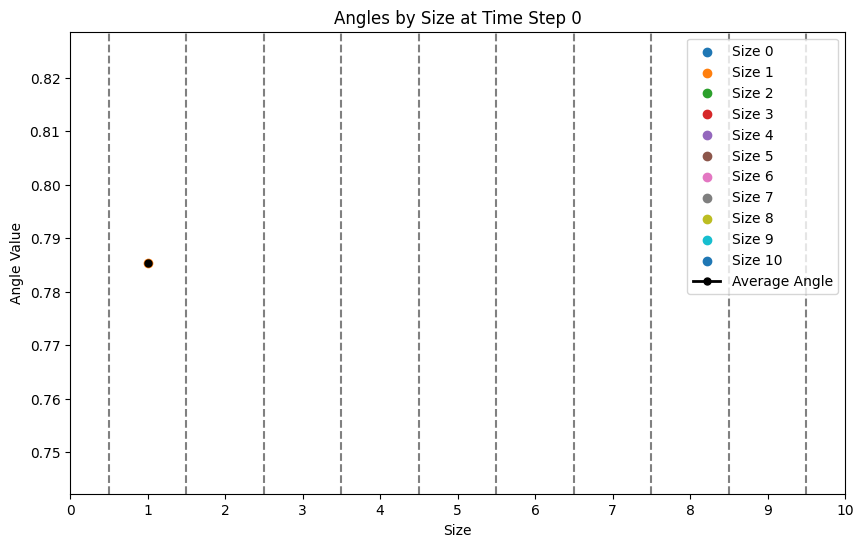

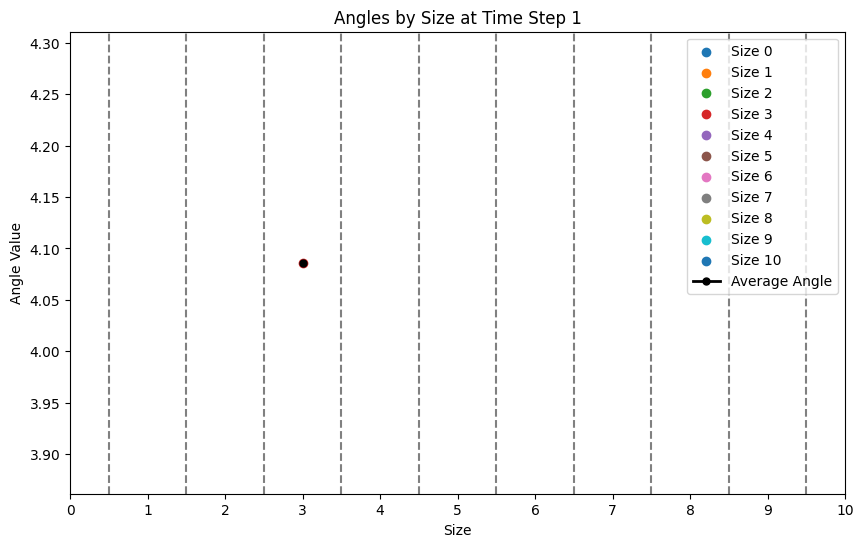

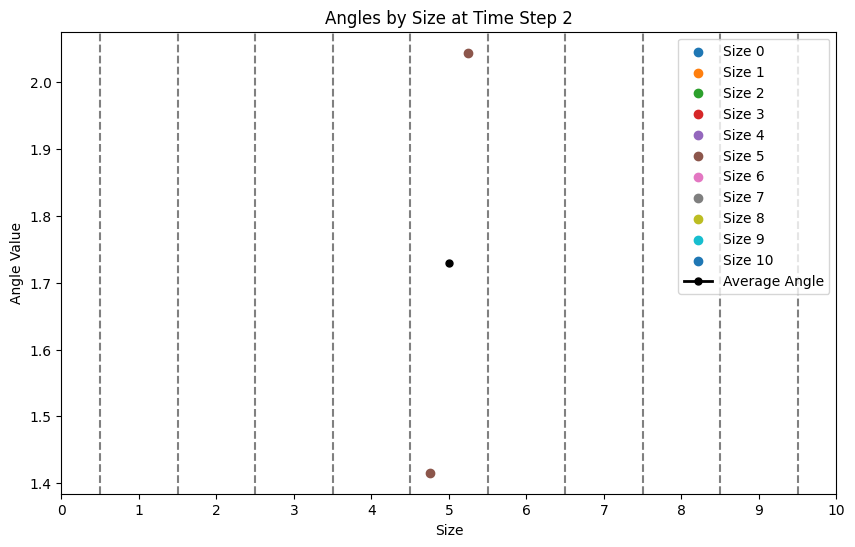

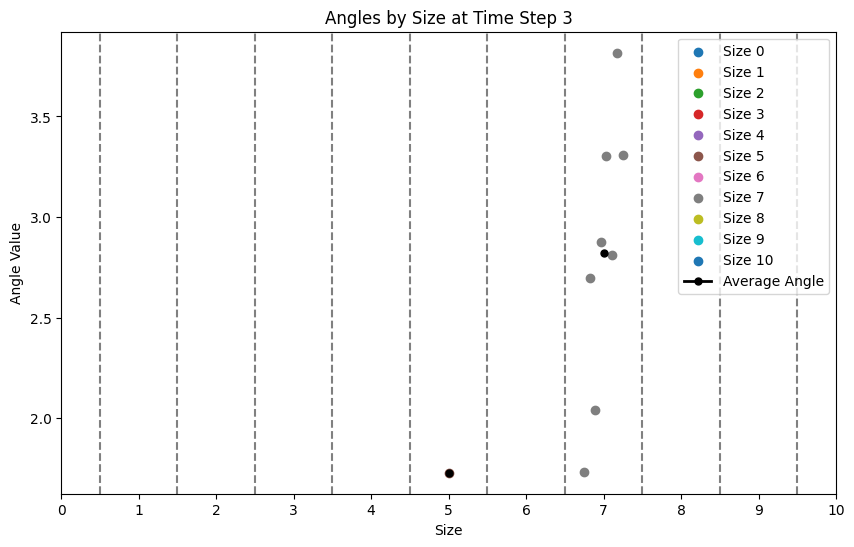

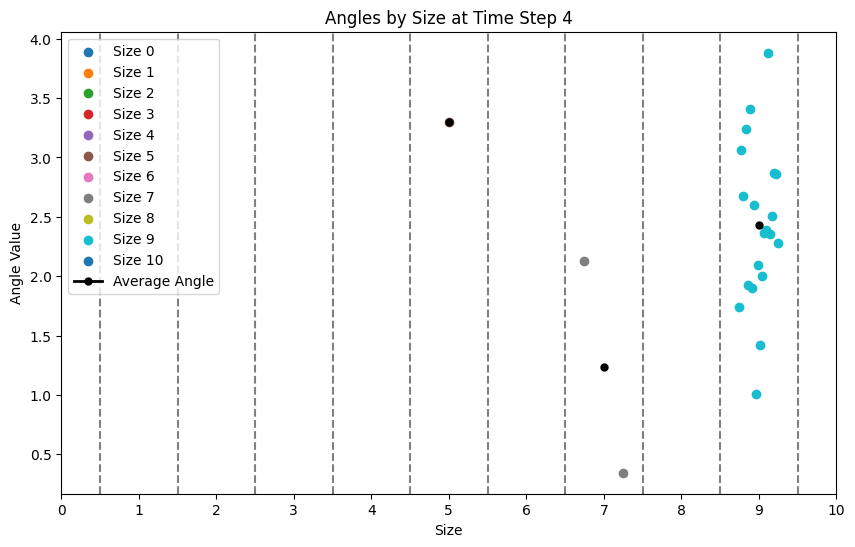

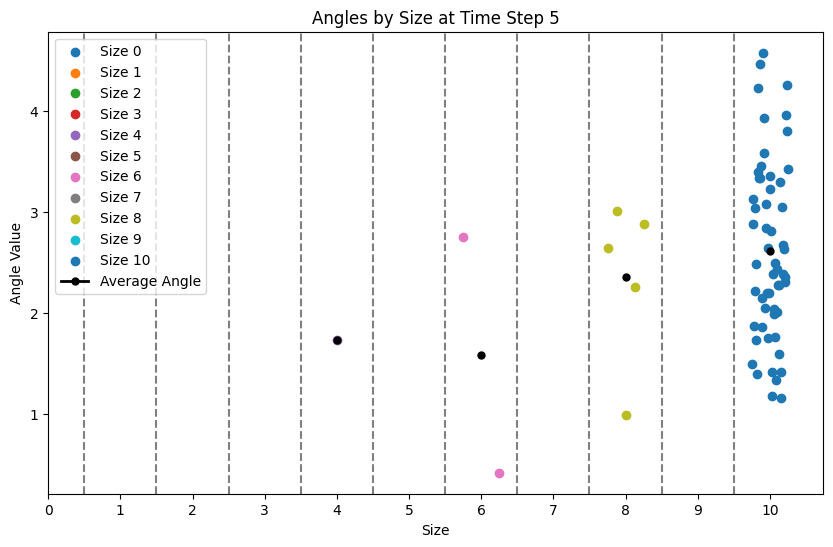

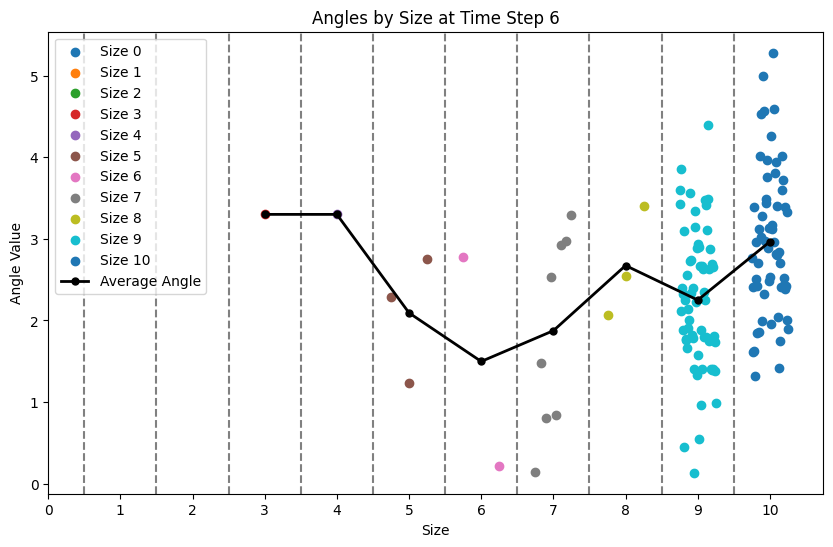

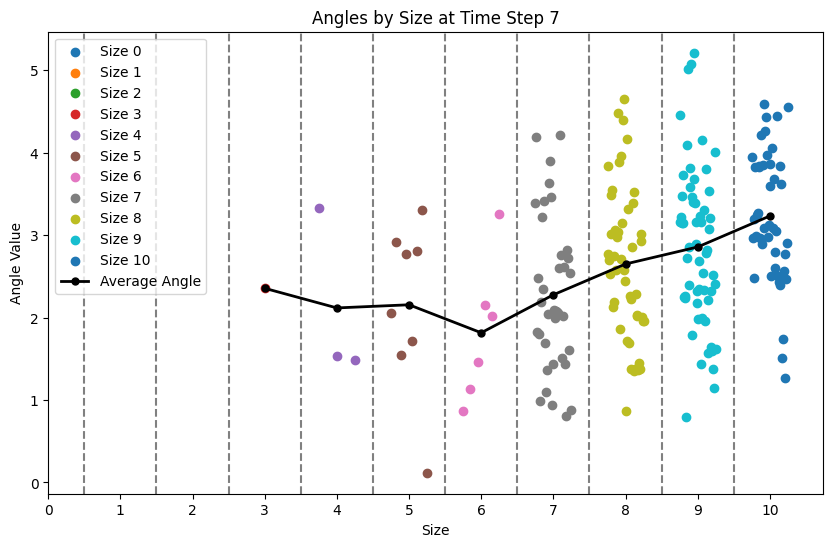

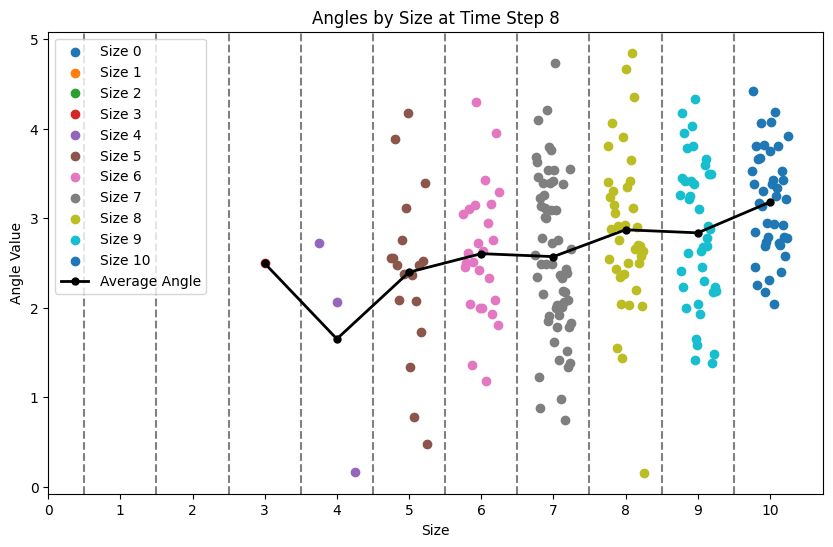

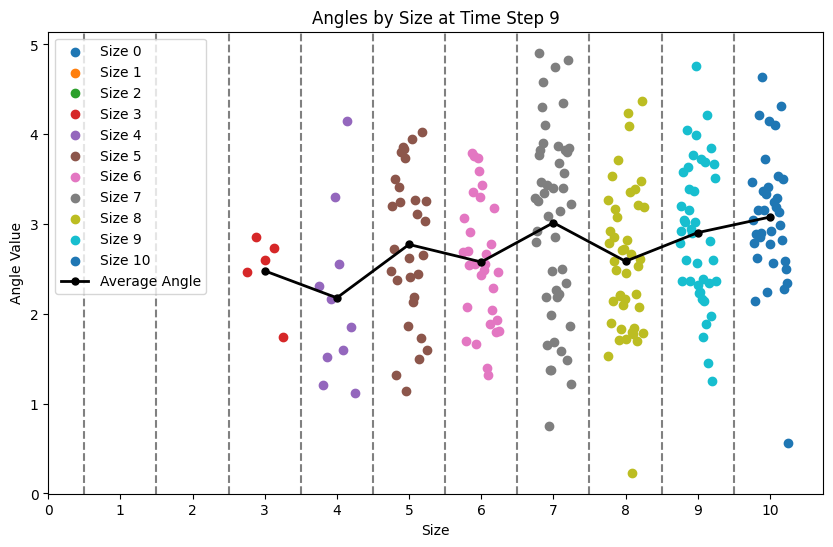

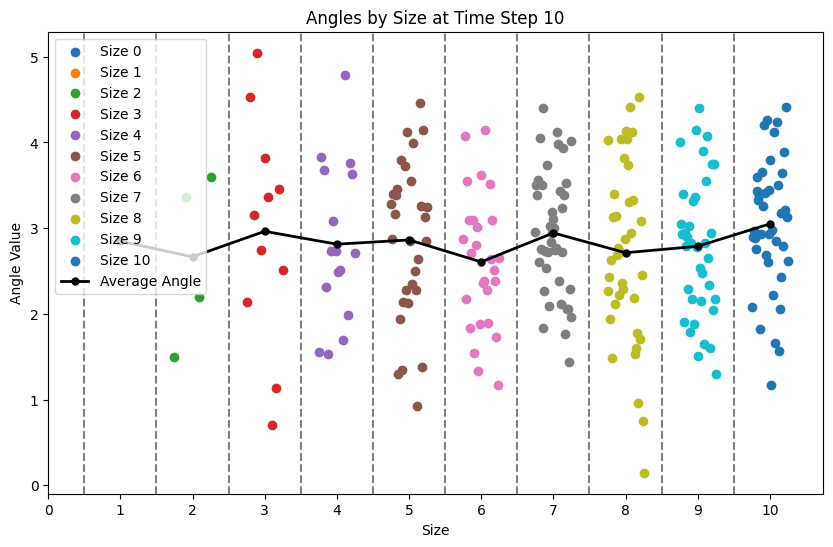

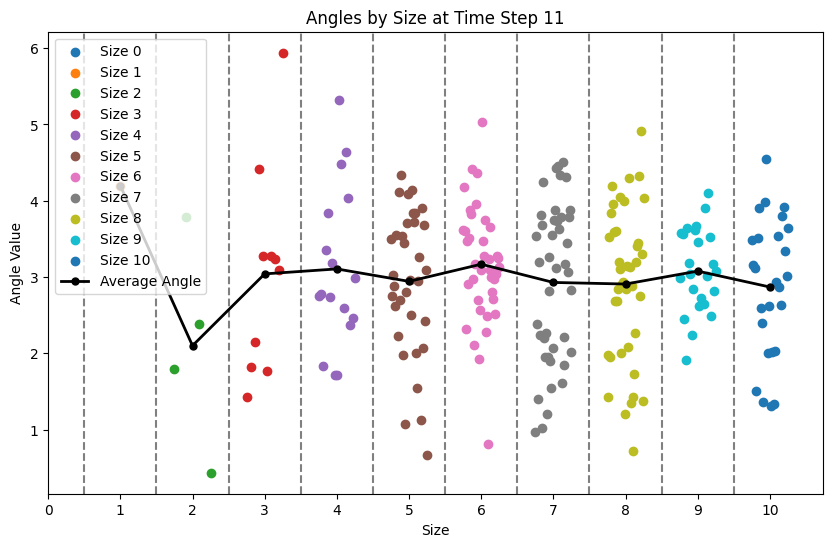

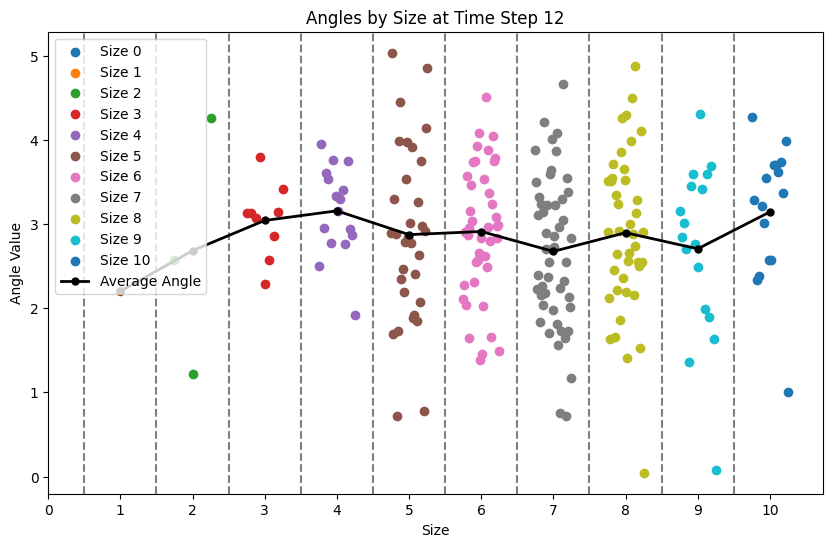

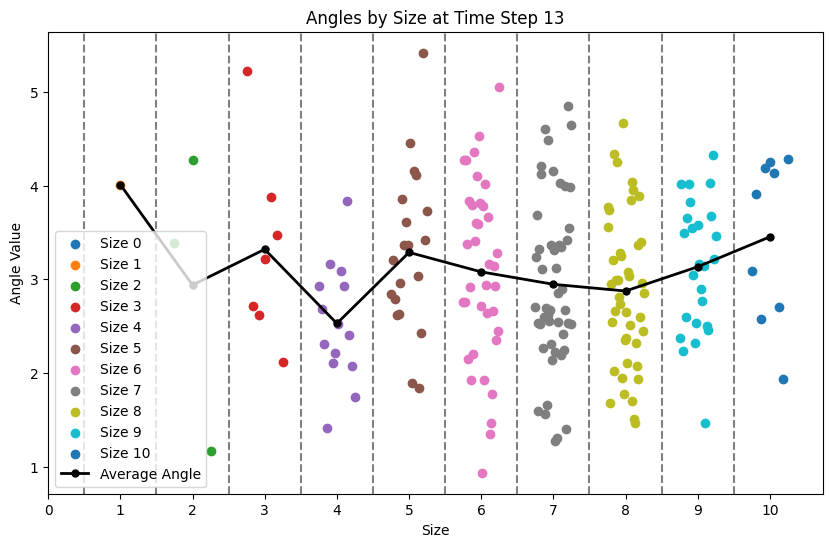

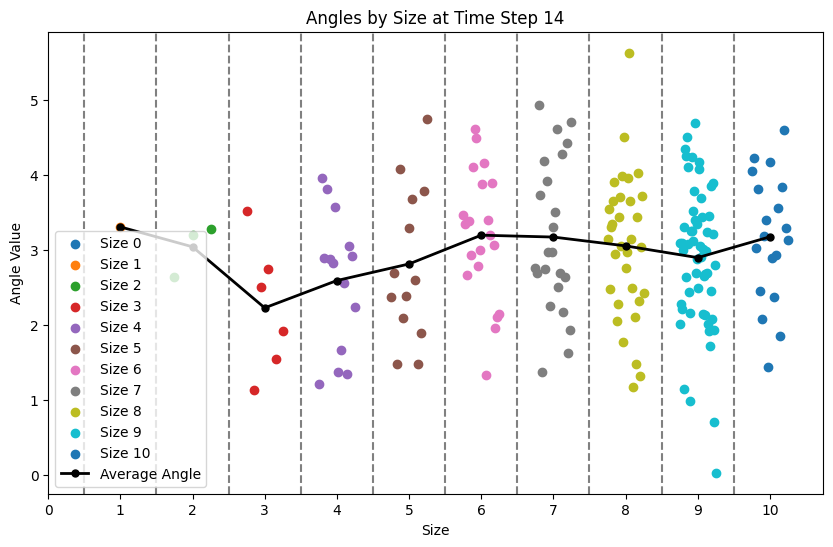

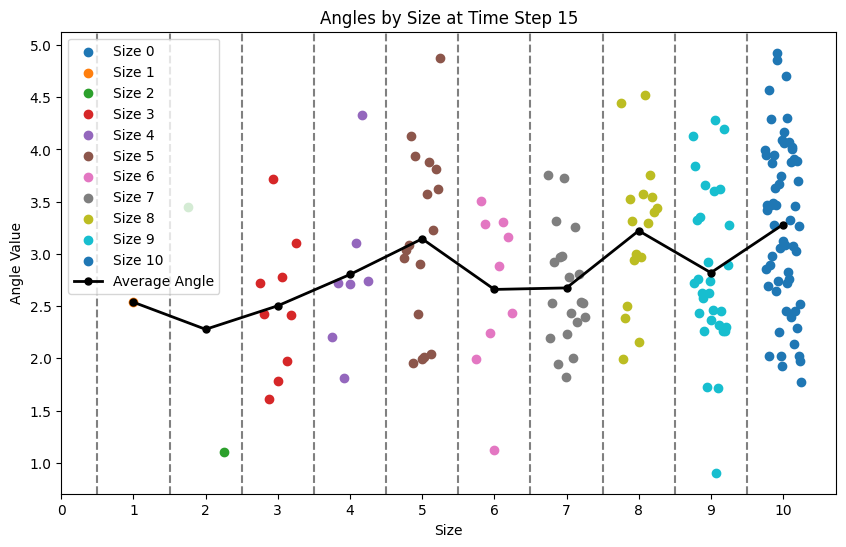

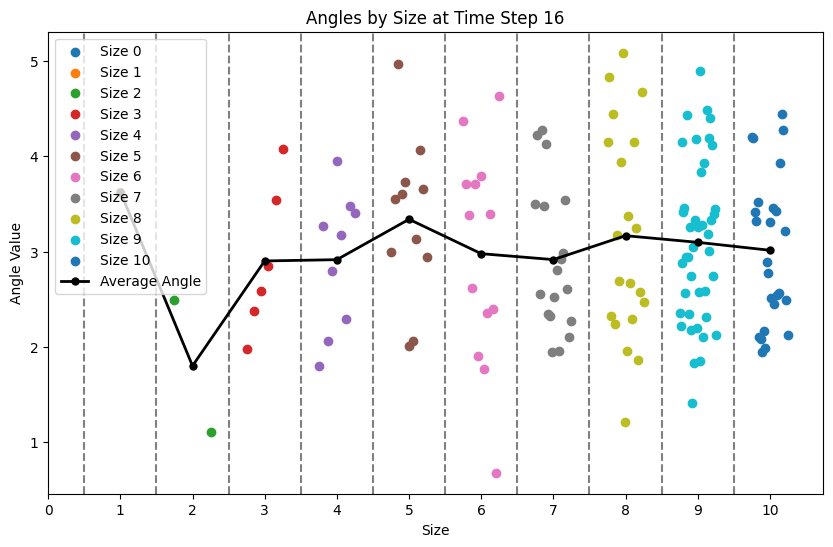

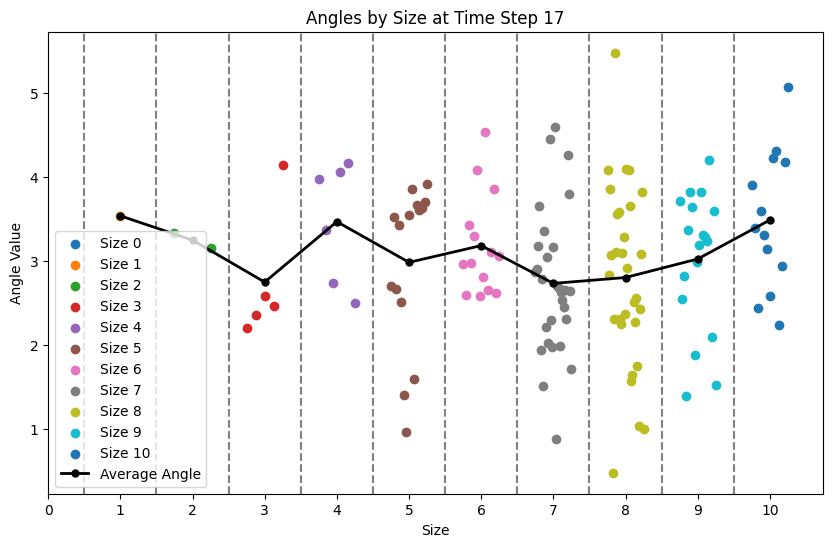

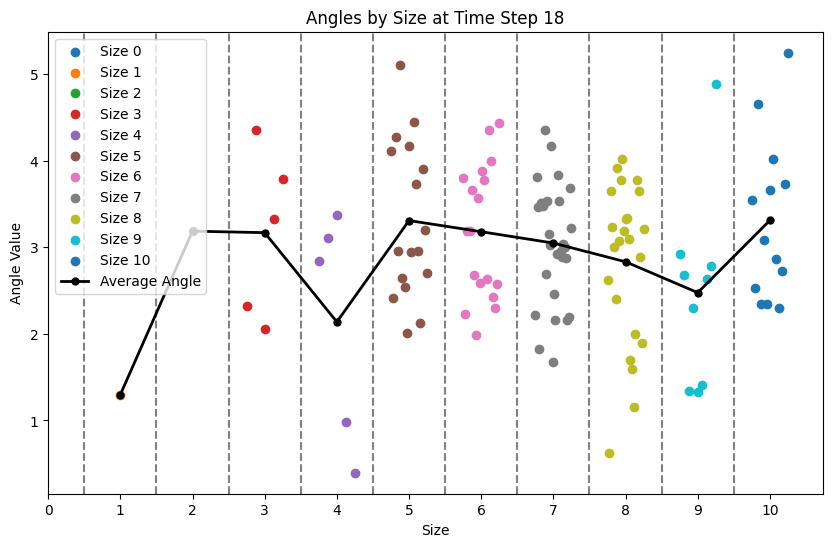

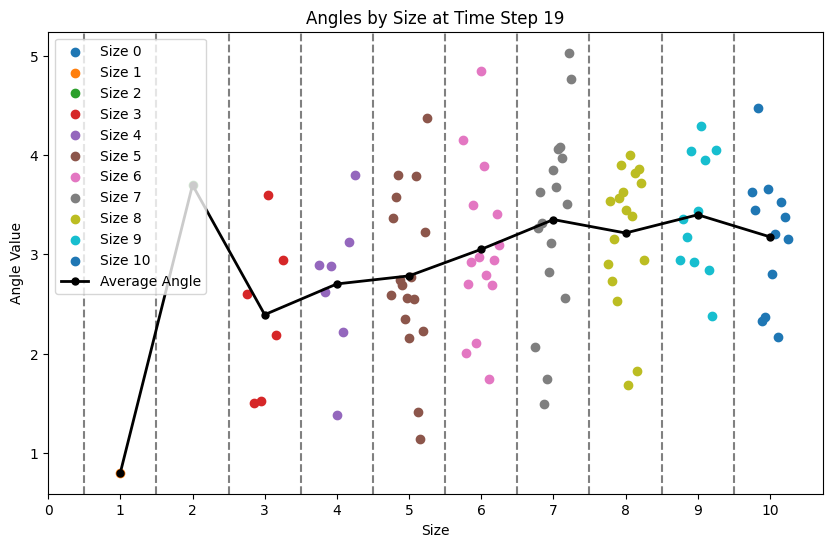

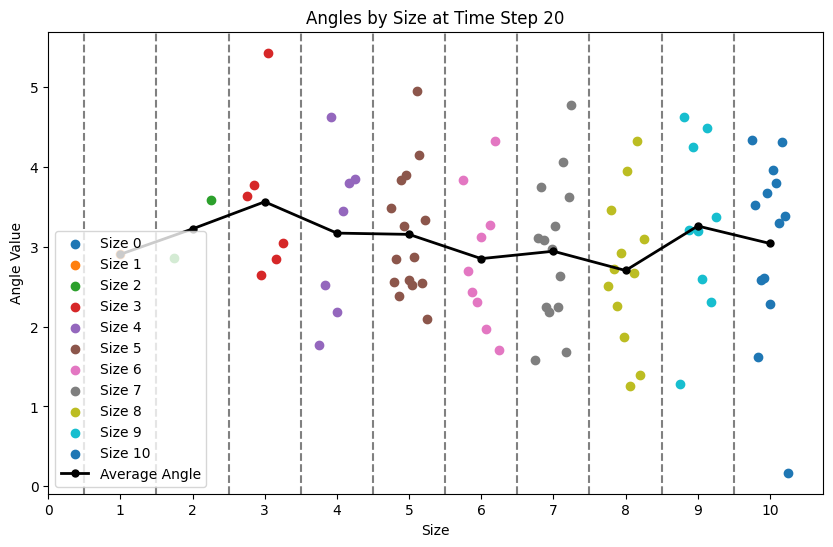

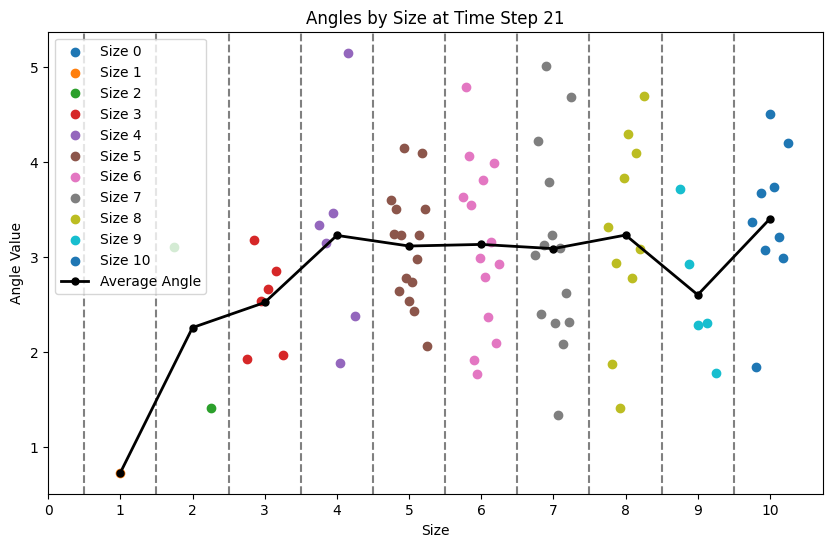

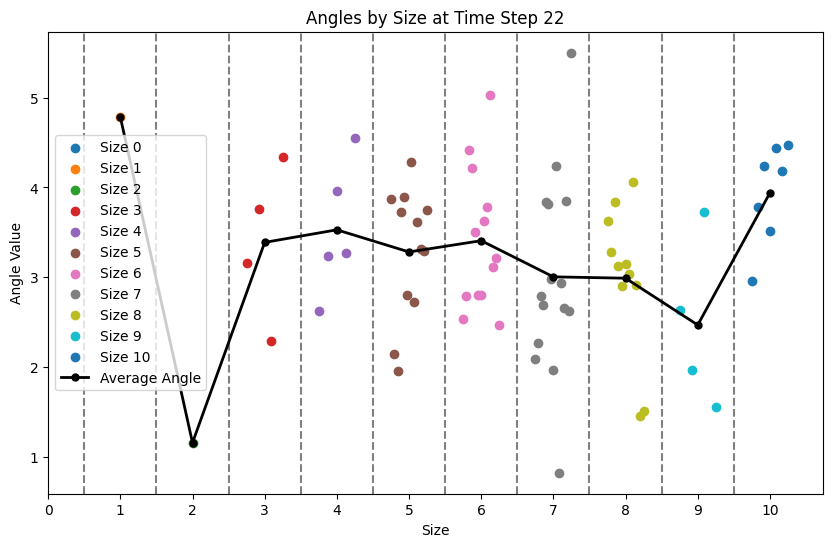

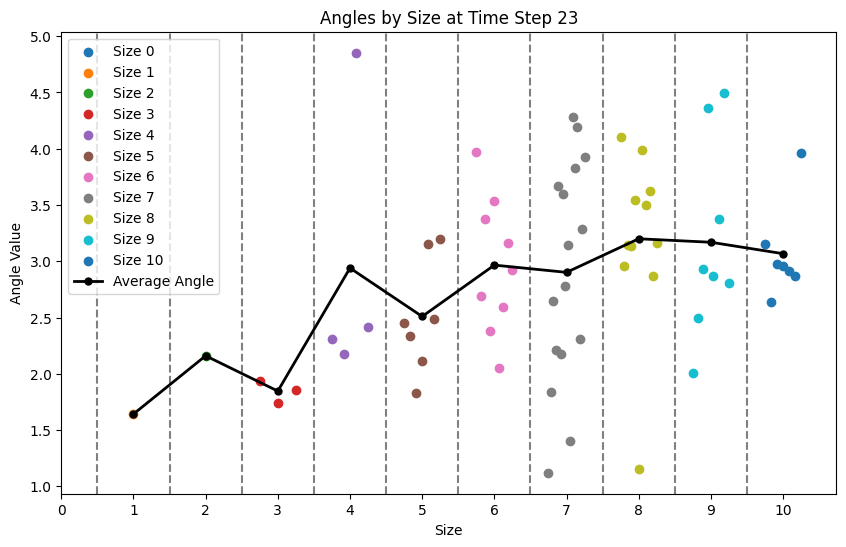

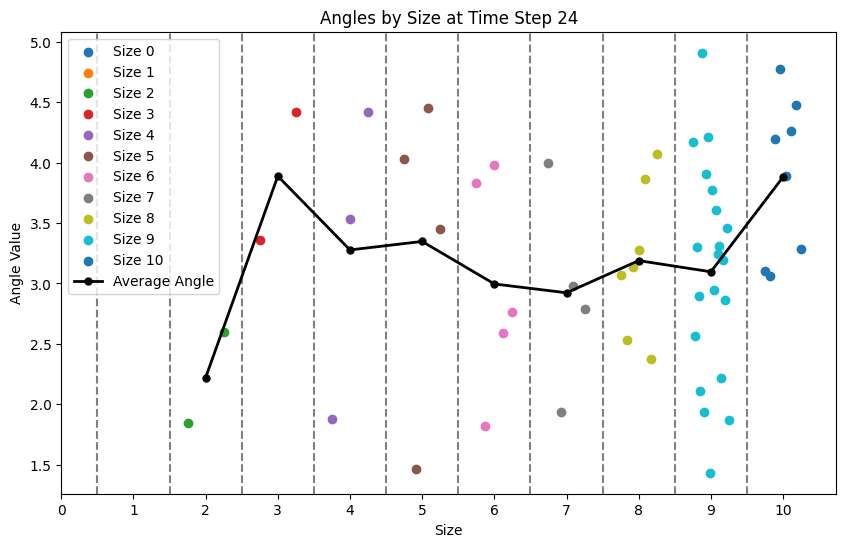

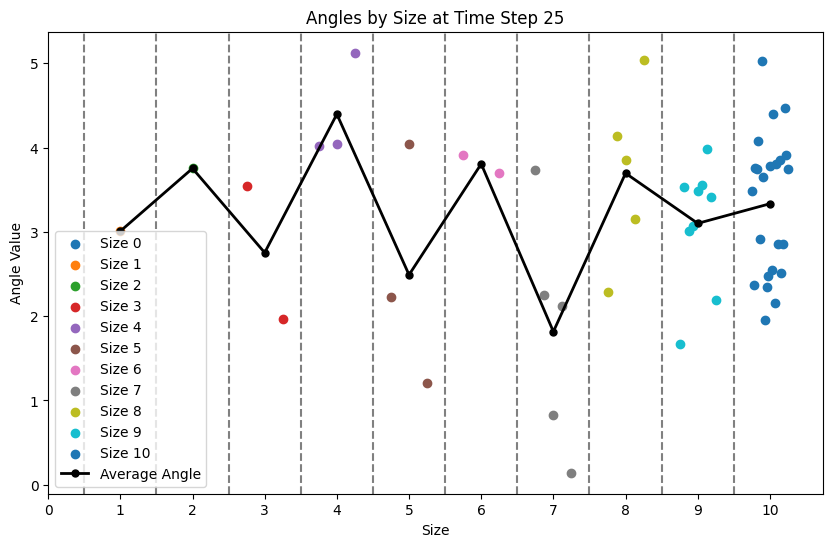

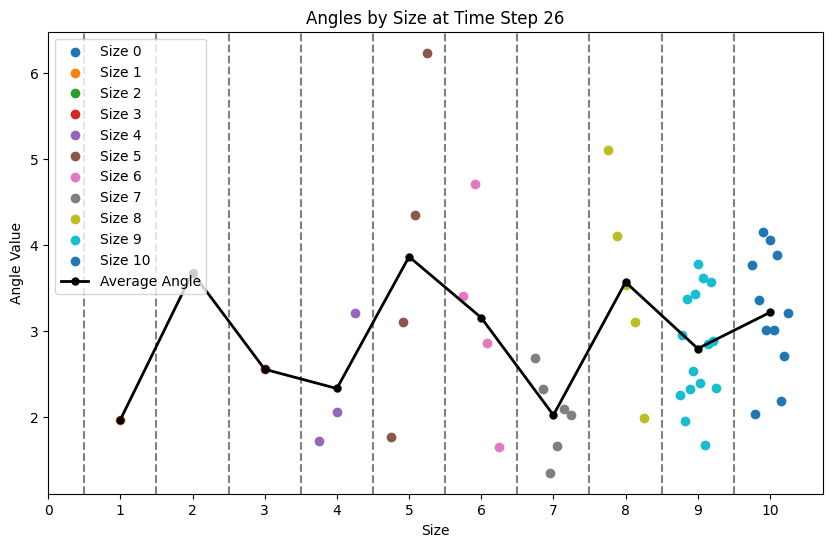

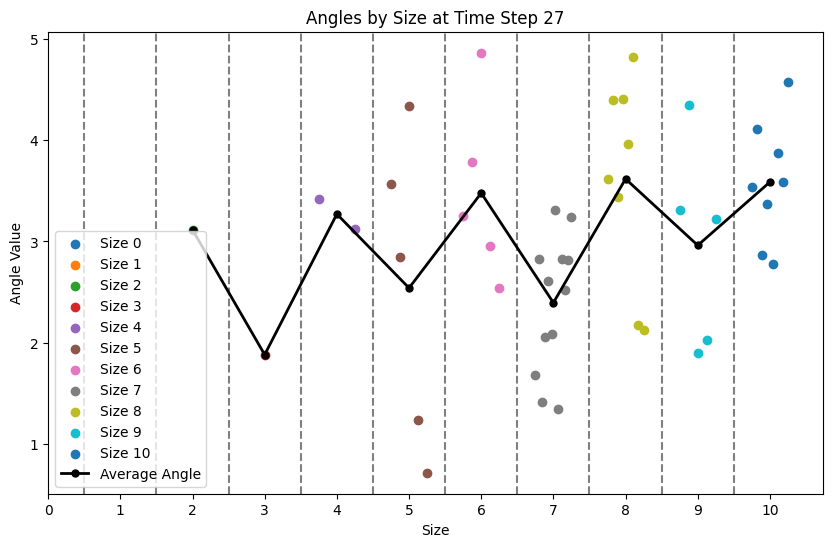

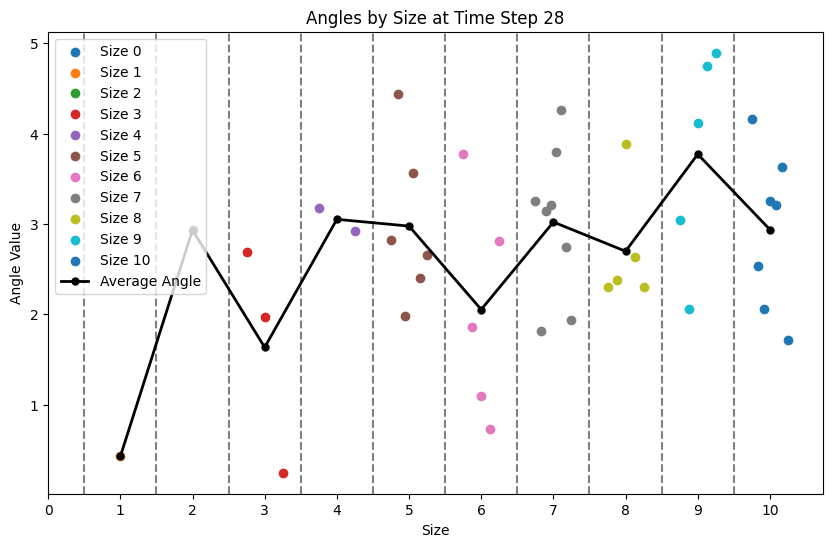

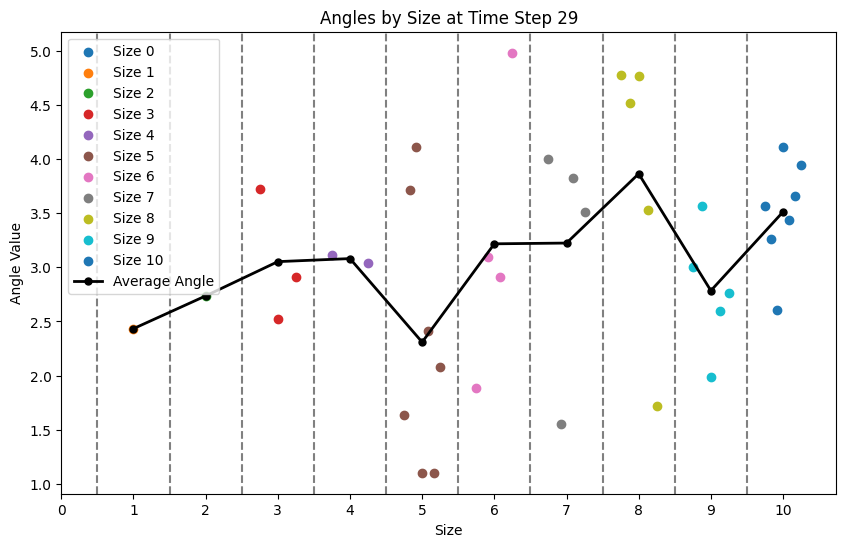

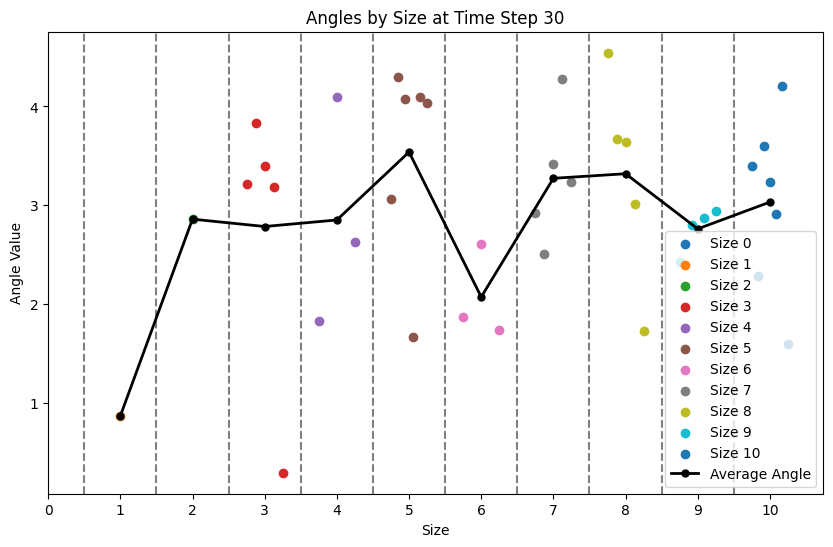

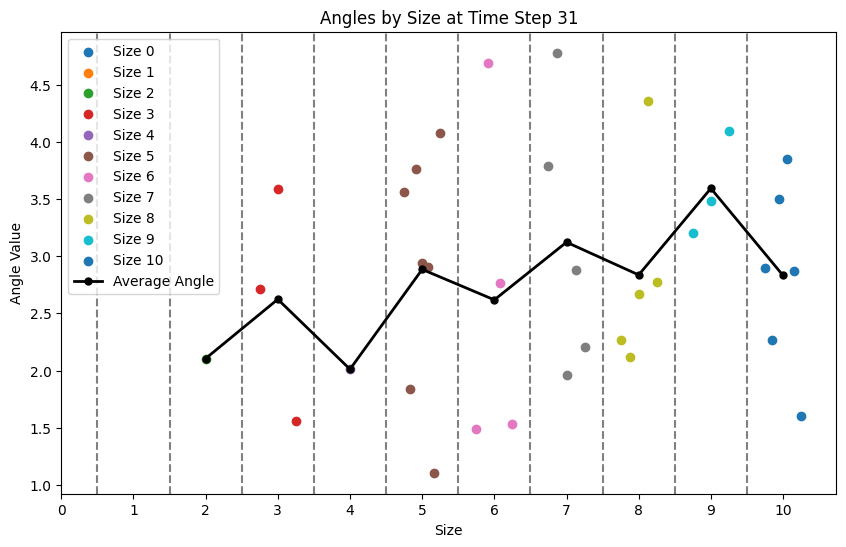

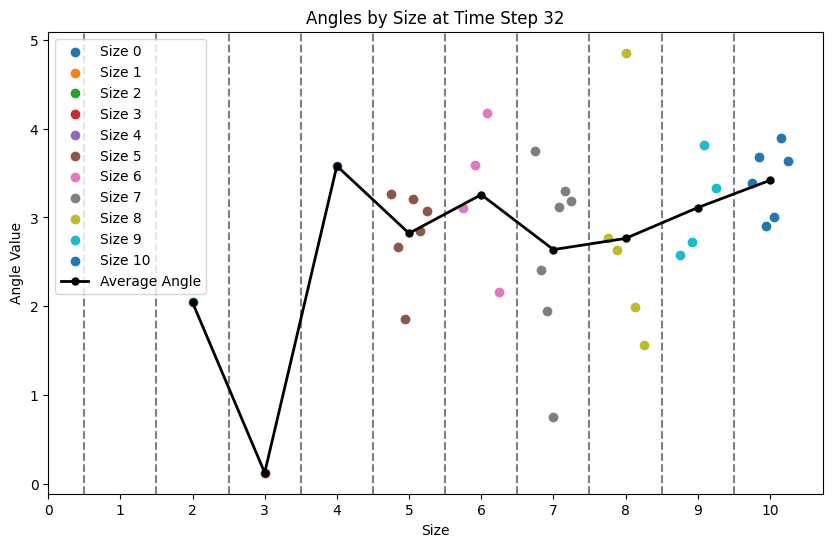

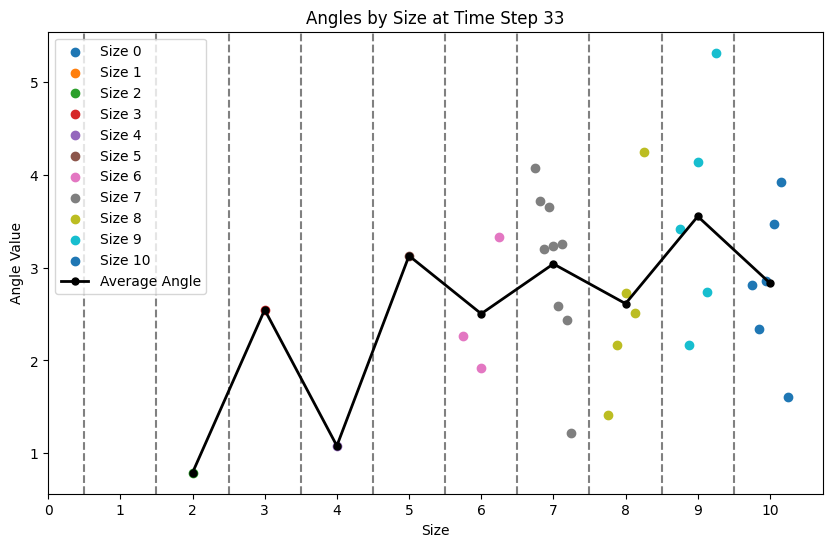

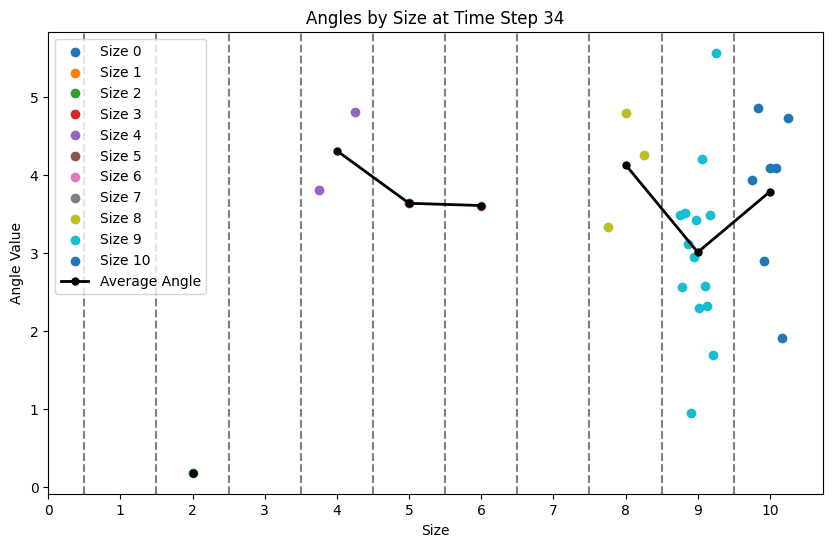

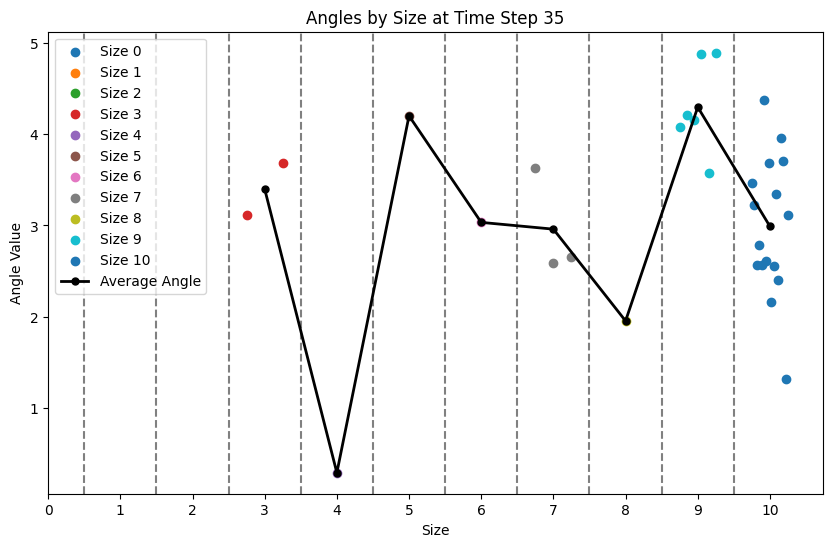

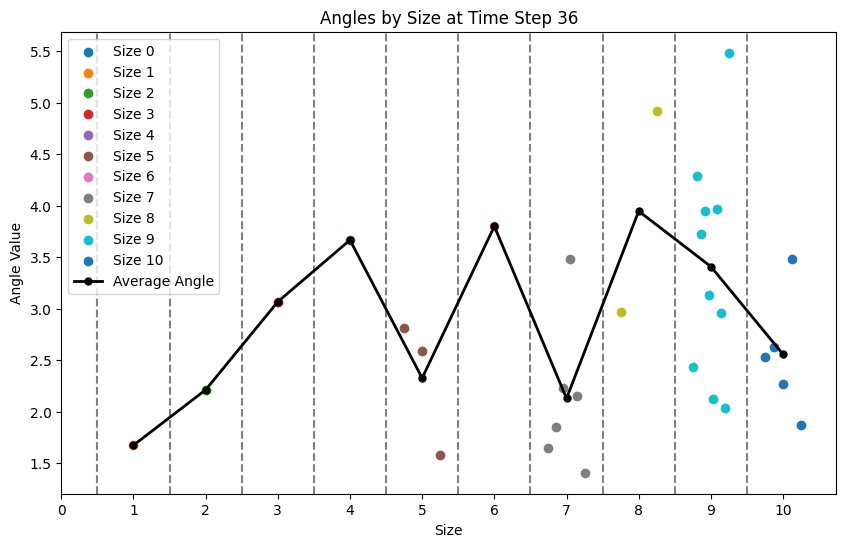

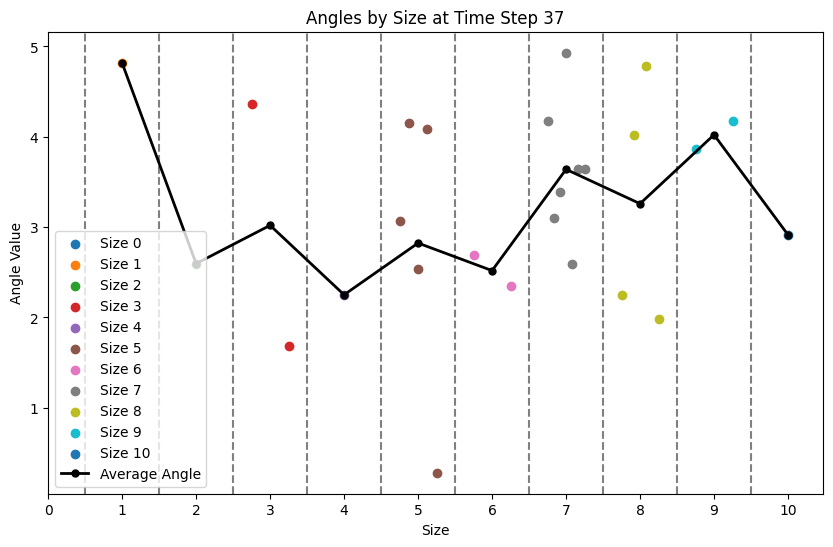

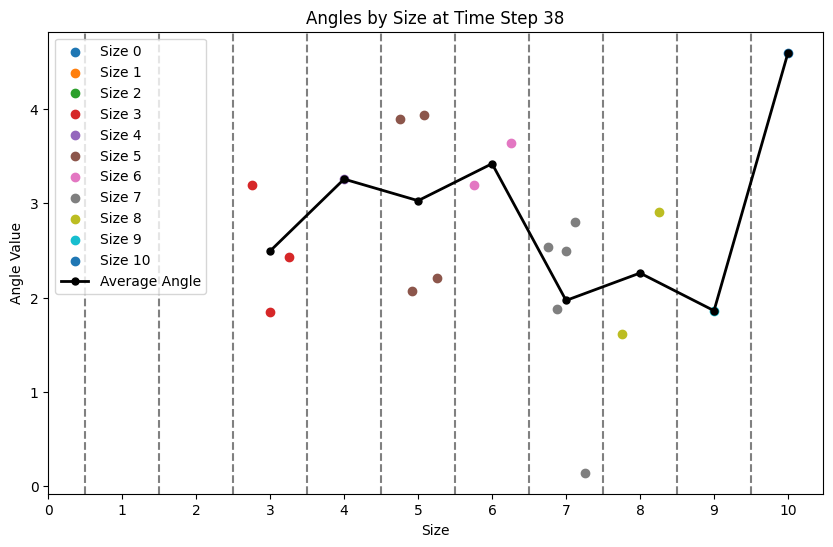

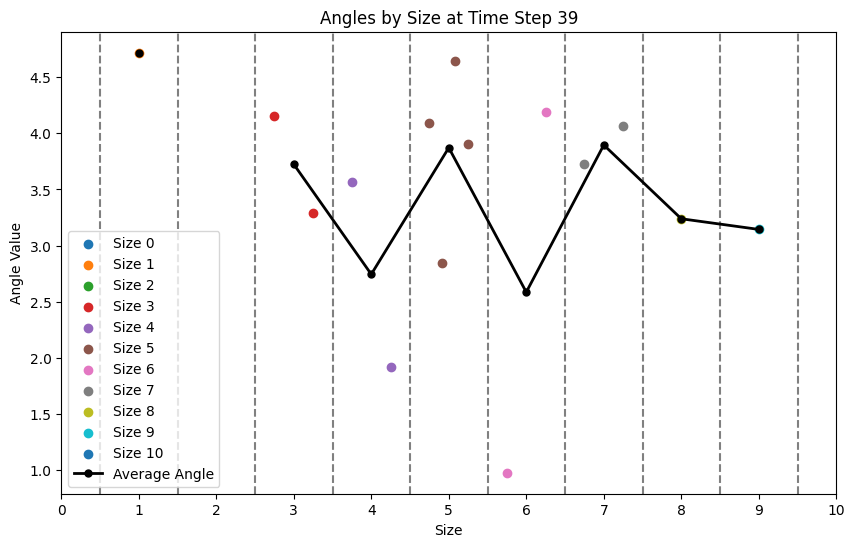

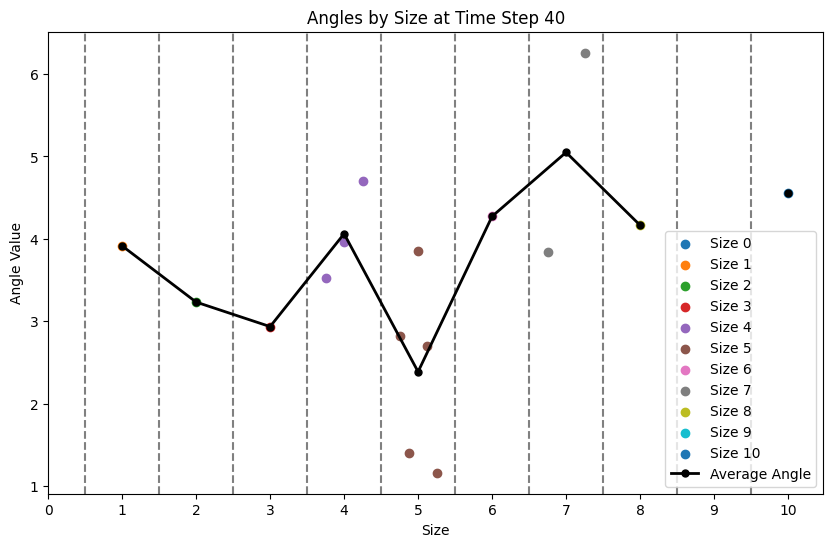

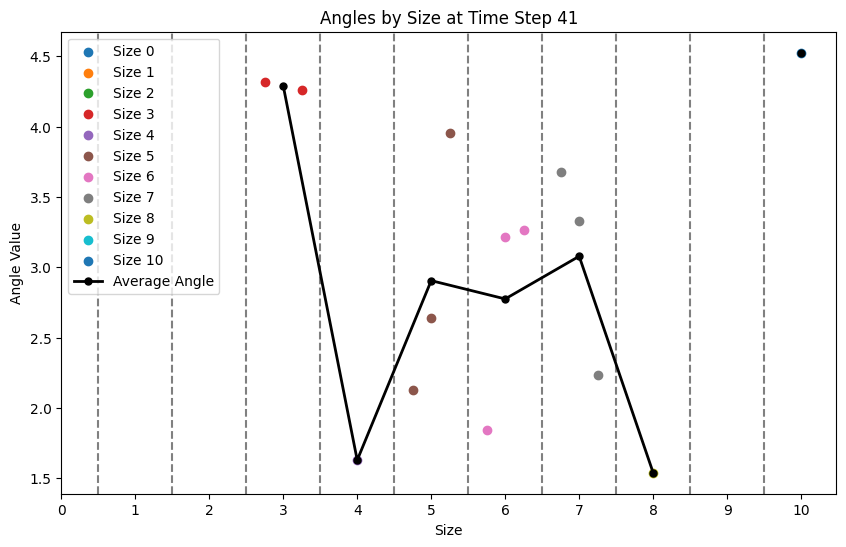

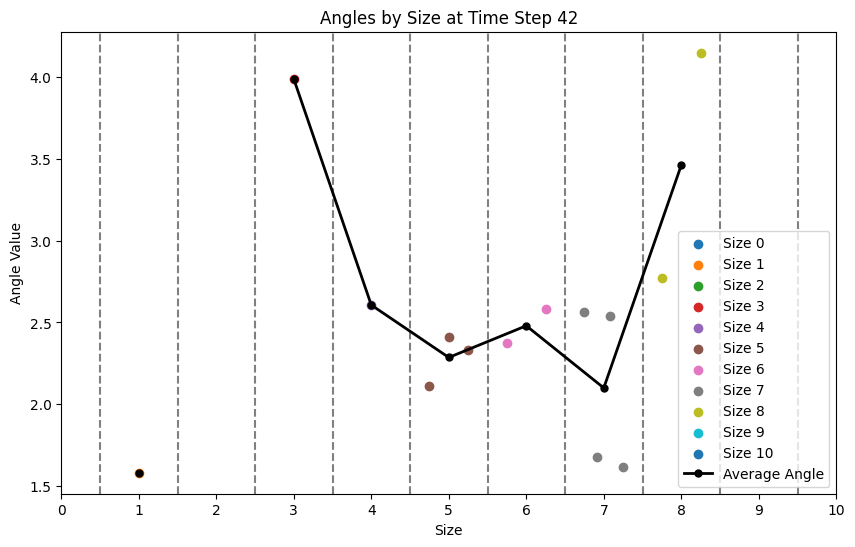

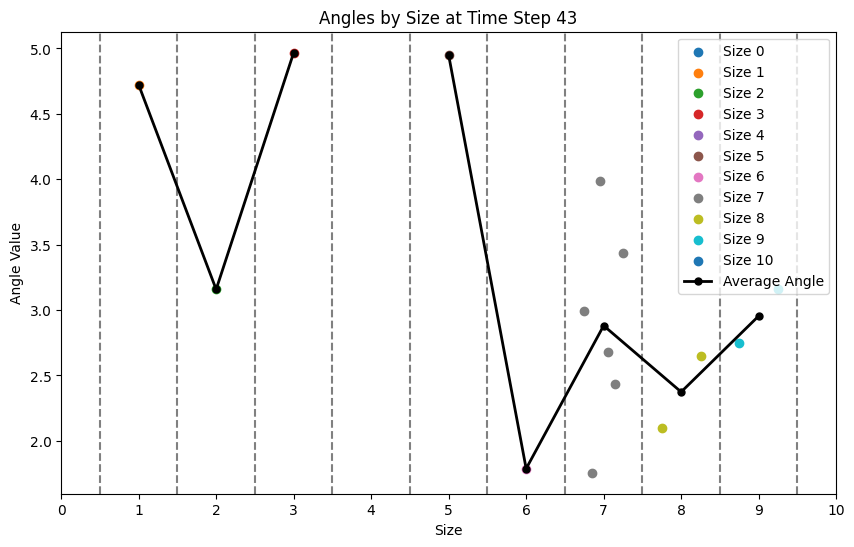

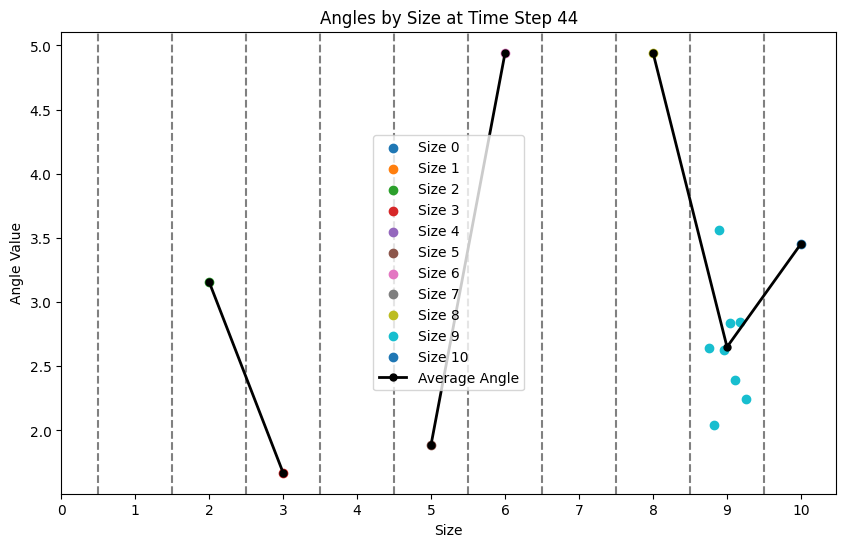

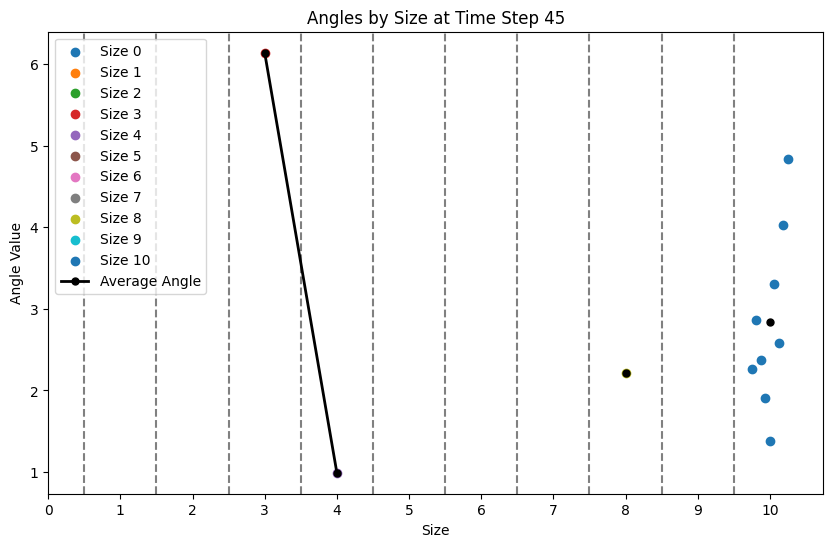

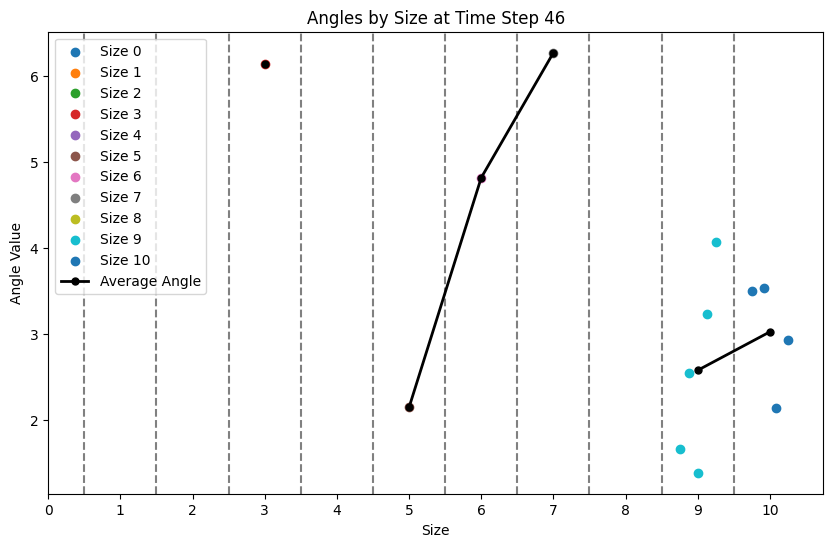

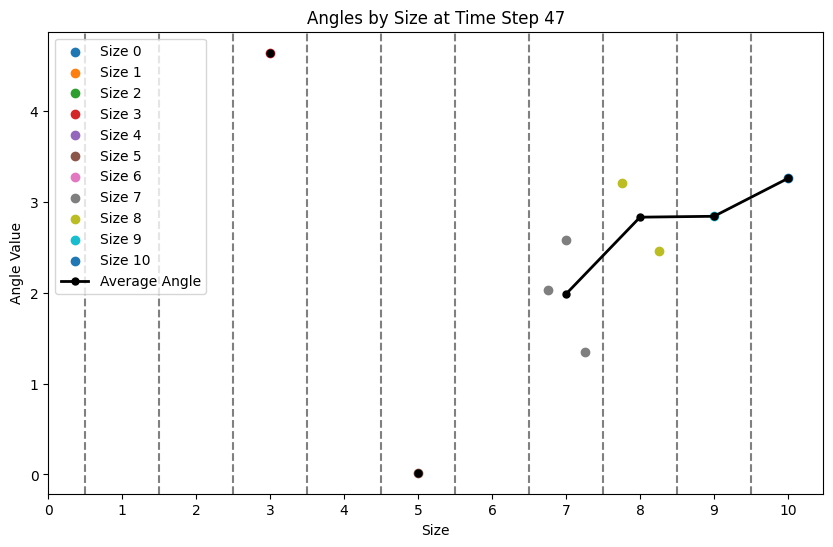

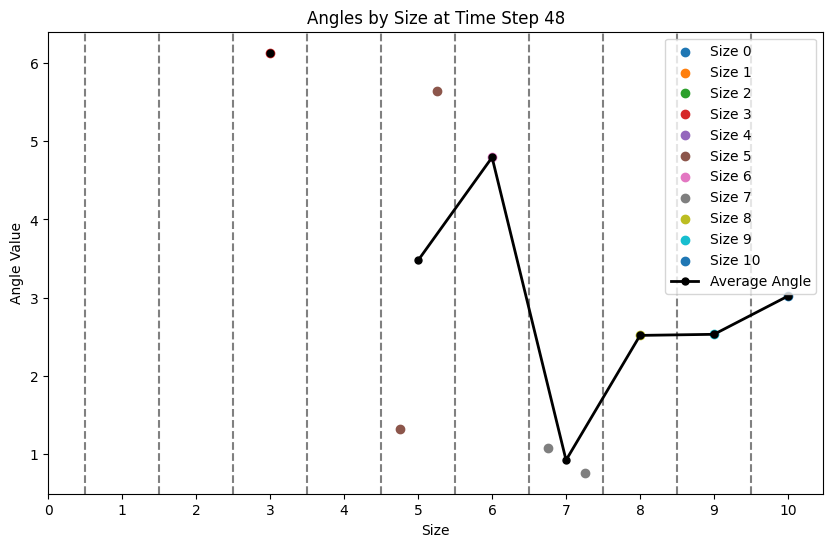

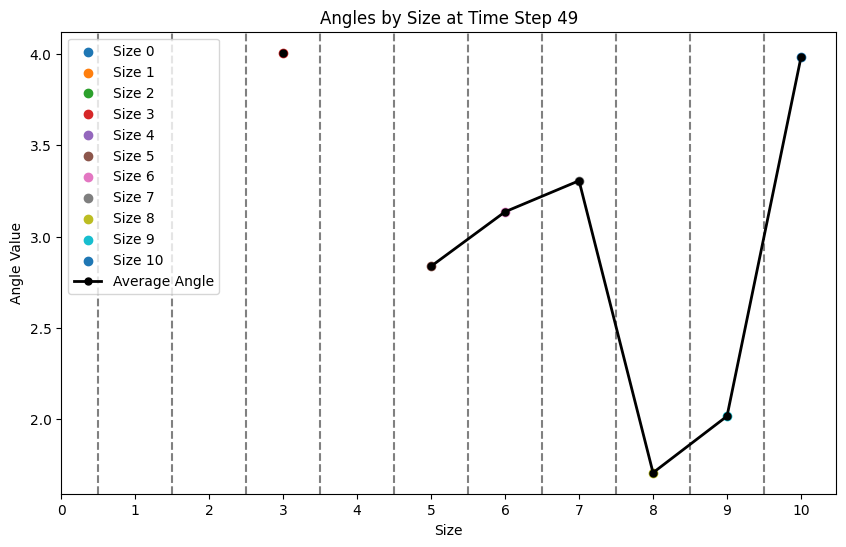

In [35]:
plots(time,Q, condition=True, coefs=q_i, paso=5)

### BKP* N=10

In [91]:
N=10
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])
h=np.array([8.34044009e-02, 1.44064899e-01, 2.28749635e-05, 6.04665145e-02,
       2.93511782e-02, 1.84677190e-02, 3.72520423e-02, 6.91121454e-02,
       7.93534948e-02, 1.07763347e-01])

time=50
q_i, q, Q = op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4), h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


#### Plot

Time 1: 1.0
Time 2: 1.0
Time 3: 1.0
Time 4: 1.0000000000000002
Time 5: 0.9999999998014845
Time 6: 0.9999999974210113
Time 7: 0.9999999871776095
Time 8: 0.9999999341775831
Time 9: 0.9999994921115813
Time 10: 0.9999976770071177
Time 11: 0.9999954443578756
Time 12: 0.999993628695563
Time 13: 0.9999951421129722
Time 14: 0.9999973542842654
Time 15: 0.9999984309258858
Time 16: 0.9999988883628264
Time 17: 0.9999991155423841
Time 18: 0.9999992509658249
Time 19: 0.9999993268237801
Time 20: 0.9999993932770888
Time 21: 0.9999994446706005
Time 22: 0.999999489559617
Time 23: 0.9999995148605283
Time 24: 0.9999995260966342
Time 25: 0.9999995532877956
Time 26: 0.999999562931156
Time 27: 0.9999995730235193
Time 28: 0.9999995869623601
Time 29: 0.9999995951749496
Time 30: 0.9999996034220106
Time 31: 0.9999996214478035
Time 32: 0.9999996250298363
Time 33: 0.9999996327575497
Time 34: 0.9999996473014572
Time 35: 0.9999996396066678
Time 36: 0.9999996488570494
Time 37: 0.9999996577103962
Time 38: 0.9999996572

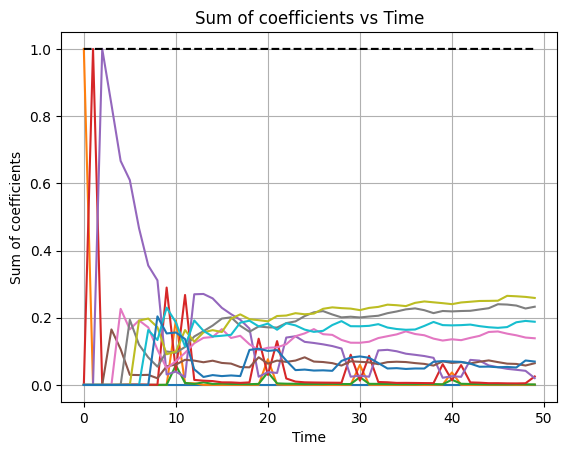

In [92]:
plots(time,Q, condition=False, coefs=q_i, paso=5)

### N=8

#### h pequeño

In [14]:
N=8
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])
h=np.array([2.08511002e-02, 3.60162247e-02, 5.71874087e-06, 1.51166286e-02,
       7.33779454e-03, 4.61692974e-03, 9.31301057e-03, 1.72780364e-02])

time=151
q_i, q, Q,sizes = op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4), h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


Time 1: 1.0
Time 2: 0.9999999999999998
Time 3: 0.9999999999984234
Time 4: 0.9999999998884611
Time 5: 0.9999999992906903
Time 6: 0.9999999971503475
Time 7: 0.9999999924875201
Time 8: 0.9999999796632485
Time 9: 0.9999999621358038
Time 10: 0.9999999363147308
Time 11: 0.9999999087508874
Time 12: 0.999999884103011
Time 13: 0.9999998515465065
Time 14: 0.9999998142412371
Time 15: 0.9999997769316258
Time 16: 0.9999997485507813
Time 17: 0.999999716043807
Time 18: 0.999999706019471
Time 19: 0.9999996900893887
Time 20: 0.9999996712371252
Time 21: 0.9999996423157279
Time 22: 0.9999996129305108
Time 23: 0.9999995880566951
Time 24: 0.9999995600541358
Time 25: 0.9999995388372962
Time 26: 0.9999995334848601
Time 27: 0.9999995302561216
Time 28: 0.9999995233712359
Time 29: 0.9999995037291417
Time 30: 0.9999994915964087
Time 31: 0.9999994744906402
Time 32: 0.9999994668997451
Time 33: 0.9999994683214583
Time 34: 0.9999994743059313
Time 35: 0.9999994826795271
Time 36: 0.9999994832086102
Time 37: 0.99999948

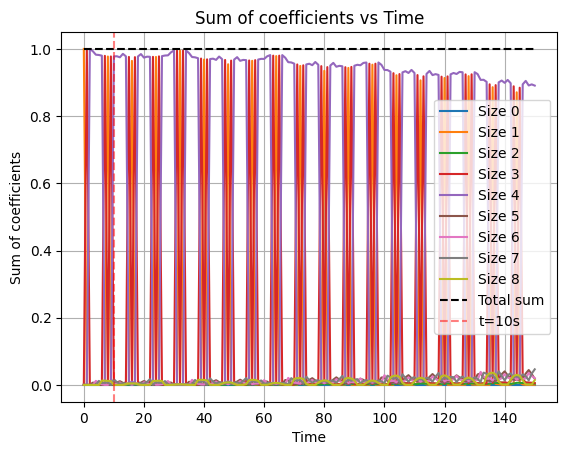

In [15]:
plots(time,Q, condition=False, coefs=q_i, paso=5)

### BKP N=10, h=0.2, b=pi/4, J=(pi/4)+0.05, V='IX'+'I's

In [85]:
N=10
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])
h=np.array([8.34044009e-02, 1.44064899e-01, 2.28749635e-05, 6.04665145e-02,
       2.93511782e-02, 1.84677190e-02, 3.72520423e-02, 6.91121454e-02,
       7.93534948e-02, 1.07763347e-01])

time=50
q_i, q, Q,sizes = op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4)+0.05, h_random=h)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


#### Plot

Time 1: 1.0
Time 2: 1.0
Time 3: 0.999999999812546
Time 4: 0.9999999990072477
Time 5: 0.999999991639457
Time 6: 0.9999999622012248
Time 7: 0.9999998357879327
Time 8: 0.9999993077276217
Time 9: 0.9999973151863217
Time 10: 0.999992568891645
Time 11: 0.9999904943997996
Time 12: 0.9999916218622324
Time 13: 0.9999934796110055
Time 14: 0.9999951418610596
Time 15: 0.9999962319338268
Time 16: 0.9999969563614245
Time 17: 0.9999975078052453
Time 18: 0.999997965187024
Time 19: 0.9999983384638176
Time 20: 0.9999985992131655
Time 21: 0.9999988095686647
Time 22: 0.9999989755030353
Time 23: 0.9999990712210567
Time 24: 0.9999991550748658
Time 25: 0.9999992324538816
Time 26: 0.9999992854836011
Time 27: 0.9999993200992537
Time 28: 0.9999993478270164
Time 29: 0.9999993755942529
Time 30: 0.9999994067559044
Time 31: 0.999999425157257
Time 32: 0.9999994405468888
Time 33: 0.9999994635722567
Time 34: 0.9999994765446865
Time 35: 0.9999995053192666
Time 36: 0.999999509496699
Time 37: 0.9999995230877414
Time 38: 

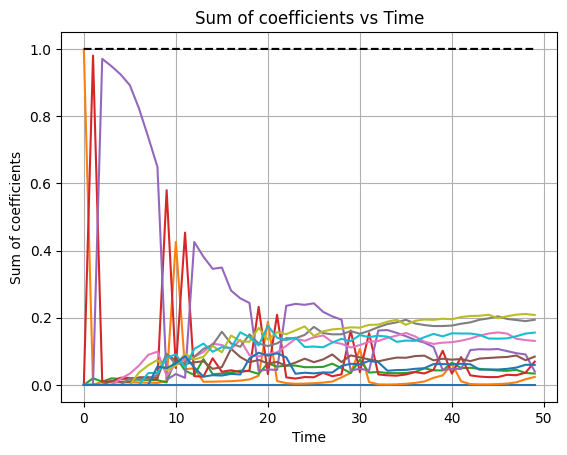

In [86]:
plots(time,Q, condition=False, coefs=q_i, paso=5)

### BKP N=10, h=0.2, b=pi/4, J=(pi/4)-0.05, V='IX'+'I's

In [87]:
N=10
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])

h=np.array([8.34044009e-02, 1.44064899e-01, 2.28749635e-05, 6.04665145e-02,
       2.93511782e-02, 1.84677190e-02, 3.72520423e-02, 6.91121454e-02,
       7.93534948e-02, 1.07763347e-01])
time=50
q_i, q, Q,sizes = op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4)-0.05, h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


#### Plot

Time 1: 1.0
Time 2: 1.0
Time 3: 0.9999999999418111
Time 4: 0.99999999958843
Time 5: 0.9999999960469848
Time 6: 0.9999999761197659
Time 7: 0.9999998806525477
Time 8: 0.9999994287558875
Time 9: 0.9999973082625719
Time 10: 0.9999927798226503
Time 11: 0.9999931812868965
Time 12: 0.999995710445666
Time 13: 0.9999972893871282
Time 14: 0.9999981292835451
Time 15: 0.9999985577876197
Time 16: 0.9999988094074922
Time 17: 0.9999989838718876
Time 18: 0.9999990936111648
Time 19: 0.9999992353180513
Time 20: 0.9999993160946495
Time 21: 0.9999993910516198
Time 22: 0.9999994400505513
Time 23: 0.9999994719629237
Time 24: 0.9999995044780451
Time 25: 0.9999995395585128
Time 26: 0.9999995565668606
Time 27: 0.9999995749131081
Time 28: 0.9999995837855985
Time 29: 0.9999995925869214
Time 30: 0.9999996043775604
Time 31: 0.9999996166903824
Time 32: 0.9999996221649499
Time 33: 0.9999996295932925
Time 34: 0.9999996357495268
Time 35: 0.9999996406348537
Time 36: 0.9999996500513363
Time 37: 0.9999996531532328
Time 3

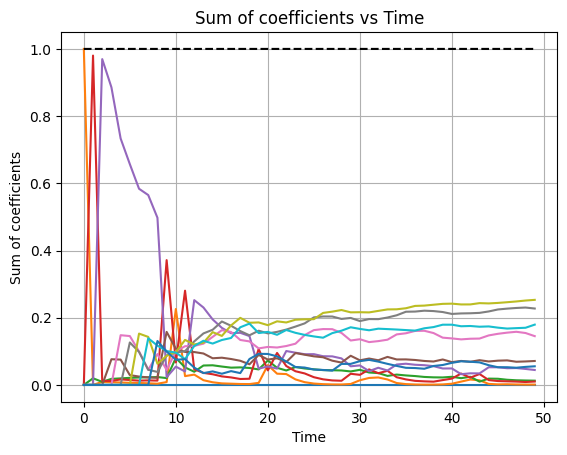

In [88]:
plots(time,Q, condition=False, coefs=q_i, paso=5)

### BKP* N=12, h=0.0, V='IX'+'I's

In [89]:
N=12
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])
h=np.zeros(N)

time=50
q_i, q, Q ,sizes= op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4), h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


#### Plot

Time 1: 1.0
Time 2: 1.0000000000000044
Time 3: 1.0000000000000098
Time 4: 1.000000000000015
Time 5: 1.0000000000000204
Time 6: 1.0000000000000258
Time 7: 1.000000000000031
Time 8: 1.0000000000000364
Time 9: 1.0000000000000417
Time 10: 1.000000000000047
Time 11: 1.0000000000000524
Time 12: 1.0000000000000577
Time 13: 1.000000000000063
Time 14: 1.0000000000000688
Time 15: 1.0000000000000746
Time 16: 1.00000000000008
Time 17: 1.0000000000000853
Time 18: 1.0000000000000906
Time 19: 1.000000000000096
Time 20: 1.0000000000001013
Time 21: 1.0000000000001066
Time 22: 1.000000000000112
Time 23: 1.0000000000001172
Time 24: 1.0000000000001226
Time 25: 1.000000000000128
Time 26: 1.0000000000001332
Time 27: 1.0000000000001386
Time 28: 1.0000000000001448
Time 29: 1.00000000000015
Time 30: 1.0000000000001554
Time 31: 1.0000000000001608
Time 32: 1.000000000000166
Time 33: 1.0000000000001714
Time 34: 1.0000000000001767
Time 35: 1.000000000000182
Time 36: 1.0000000000001874
Time 37: 1.0000000000001932
T

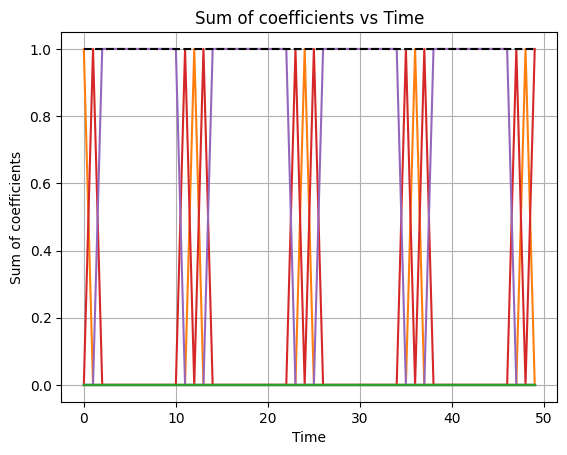

In [90]:
plots(time,Q, condition=False, coefs=q_i, paso=5)

### BKP N=12 h=0.5

In [24]:
N=12
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])
h=np.random.rand(N)*0.5

time=50
q_i, q, Q,sizes = op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4), h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Time 1: 1.0
Time 2: 1.0000000000000053
Time 3: 1.0000000000000107
Time 4: 1.0000000000000155
Time 5: 0.9999999996220694
Time 6: 0.9999999980305145
Time 7: 0.9999999844484454
Time 8: 0.9999999259614331
Time 9: 0.9999997447119728
Time 10: 0.9999990528079348
Time 11: 0.9999965659321413
Time 12: 0.9999789133454099
Time 13: 0.999953194865603
Time 14: 0.9999610067018553
Time 15: 0.9999745985180918
Time 16: 0.9999784829408108
Time 17: 0.9999801132295021
Time 18: 0.9999808127052219
Time 19: 0.9999811732103838
Time 20: 0.9999814002120803
Time 21: 0.9999814996914935
Time 22: 0.9999815993119266
Time 23: 0.9999816418745054
Time 24: 0.999981688611853
Time 25: 0.999981710912563
Time 26: 0.9999817204353041
Time 27: 0.9999816987102
Time 28: 0.999981696717524
Time 29: 0.999981731744445
Time 30: 0.9999817263891237
Time 31: 0.9999817642818281
Time 32: 0.9999816923560529
Time 33: 0.9999817348028412
Time 34: 0.999981726608694
Time 35: 0.9999817200641522
Time 36: 0.9999817885753817
Time 37: 0.99998177032546

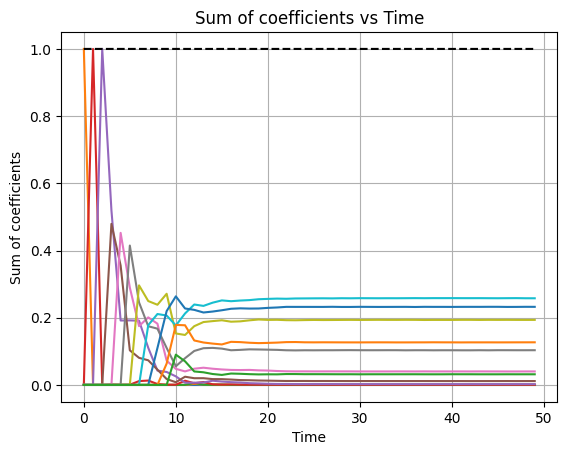

In [25]:
plots(time,Q, condition=False, coefs=q_i, paso=5)

### BKP N=12 h=0.75

In [26]:
N=12
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])
h=np.random.rand(N)*0.75

time=50
q_i, q, Q ,sizes= op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4), h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Time 1: 1.0
Time 2: 1.0000000000000056
Time 3: 1.0000000000000107
Time 4: 1.000000000000016
Time 5: 0.9999999995929223
Time 6: 0.9999999975976357
Time 7: 0.9999999902224341
Time 8: 0.9999999713828304
Time 9: 0.9999998591828619
Time 10: 0.9999992526769907
Time 11: 0.9999947924375809
Time 12: 0.9999675810013513
Time 13: 0.9999470095644116
Time 14: 0.999954272400007
Time 15: 0.9999725410719761
Time 16: 0.9999783669297473
Time 17: 0.9999804780145413
Time 18: 0.9999813017942586
Time 19: 0.9999816210136425
Time 20: 0.9999816256109593
Time 21: 0.9999816947153239
Time 22: 0.9999817638682448
Time 23: 0.9999817382288527
Time 24: 0.9999817341409634
Time 25: 0.9999817512119654
Time 26: 0.9999817012073262
Time 27: 0.9999817691281232
Time 28: 0.9999817833388062
Time 29: 0.9999817037523689
Time 30: 0.9999817697776024
Time 31: 0.9999817976433497
Time 32: 0.9999817363087943
Time 33: 0.9999816914441667
Time 34: 0.9999818001485457
Time 35: 0.9999817228288658
Time 36: 0.9999817366351375
Time 37: 0.9999817

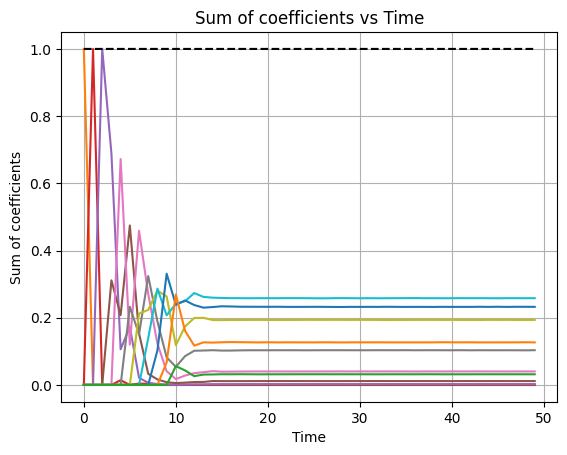

In [27]:
plots(time,Q, condition=False, coefs=q_i, paso=5)

### BKP N=10 V=H h=0.5

In [28]:
N=10

X1=Operator(PauliGate(['I'*(i-1) + 'X' + 'I'*(N-i) for i in [int(N/2)]][0]))
X2=Operator(PauliGate(['I'*(i-1) + 'Z' + 'I'*(N-i) for i in [int(N/2)]][0]))


V=1/np.sqrt(2)*(X1+1j*X2)

h=np.random.rand(N)*0.5

time=51
q_i,q, Q ,sizes= op_to_pauli(time, V, N, b=np.pi/4, J=np.pi/4, h_random=0.5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


Time 1: 0.9999999999999998
Time 2: 0.9999999999999996
Time 3: 0.9999999999999993
Time 4: 0.9999999999999999
Time 5: 0.9999999962821694
Time 6: 0.999999930887778
Time 7: 0.9999993836894933
Time 8: 0.9999973774180202
Time 9: 0.9999942942264833
Time 10: 0.9999965582872927
Time 11: 0.9999994044086579
Time 12: 0.9999999108568947
Time 13: 0.999999967732102
Time 14: 0.999999983207058
Time 15: 0.9999999871081293
Time 16: 0.9999999889571182
Time 17: 0.999999991920678
Time 18: 0.9999999912604594
Time 19: 0.9999999925150141
Time 20: 0.9999999928962869
Time 21: 0.9999999932501988
Time 22: 0.9999999927311435
Time 23: 0.9999999923977823
Time 24: 0.9999999944672069
Time 25: 0.999999994728117
Time 26: 0.9999999956392236
Time 27: 0.9999999943029048
Time 28: 0.9999999942553139
Time 29: 0.9999999948167544
Time 30: 0.999999993555664
Time 31: 0.9999999942041662
Time 32: 0.9999999940063817
Time 33: 0.9999999936733104
Time 34: 0.9999999945446582
Time 35: 0.9999999939328053
Time 36: 0.9999999931166709
Time 37

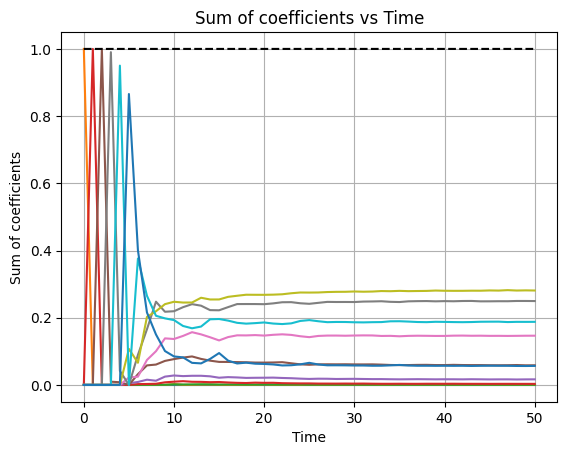

c:\Users\manue\anaconda3\envs\qutip\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\manue\anaconda3\envs\qutip\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


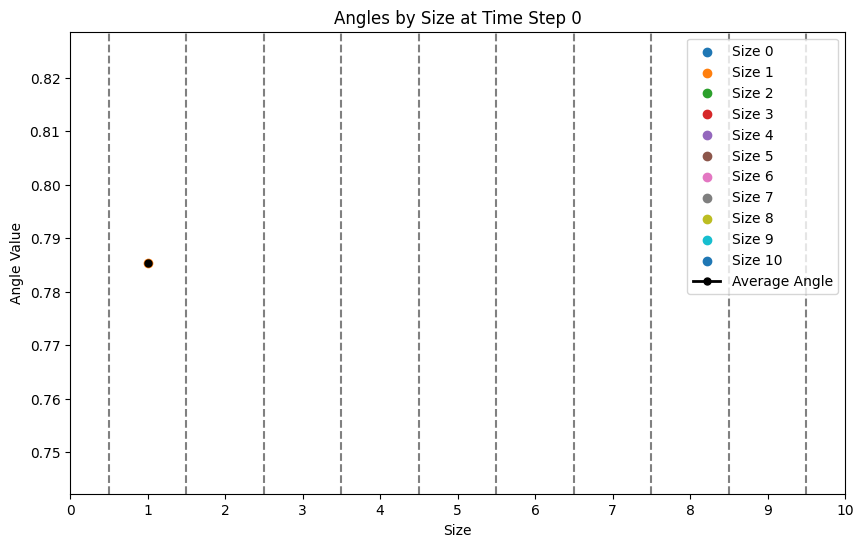

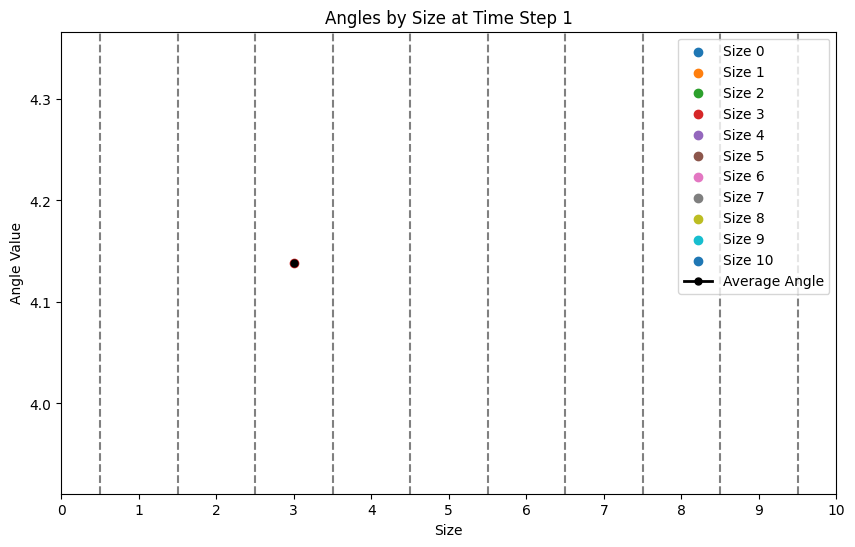

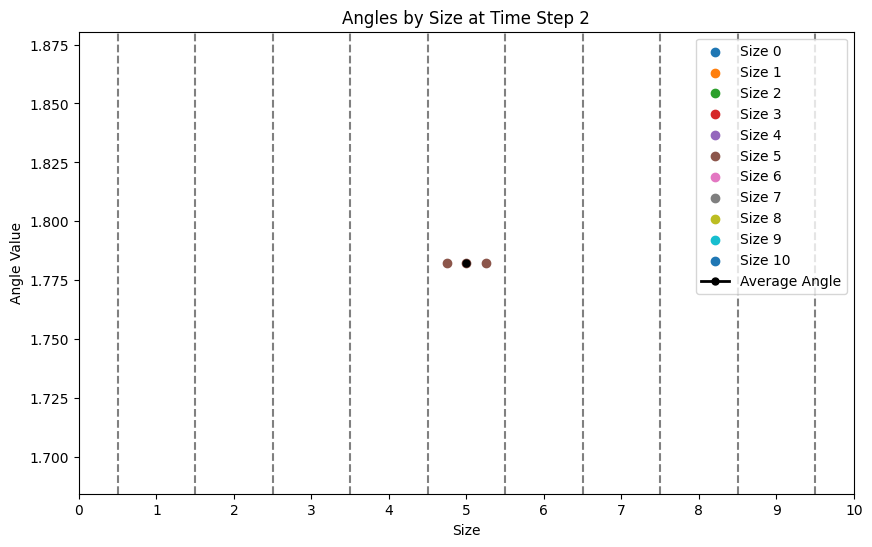

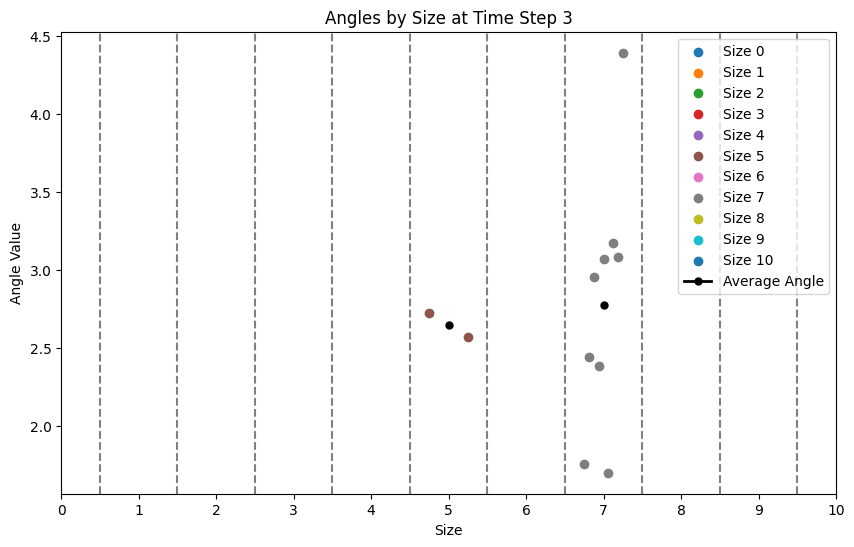

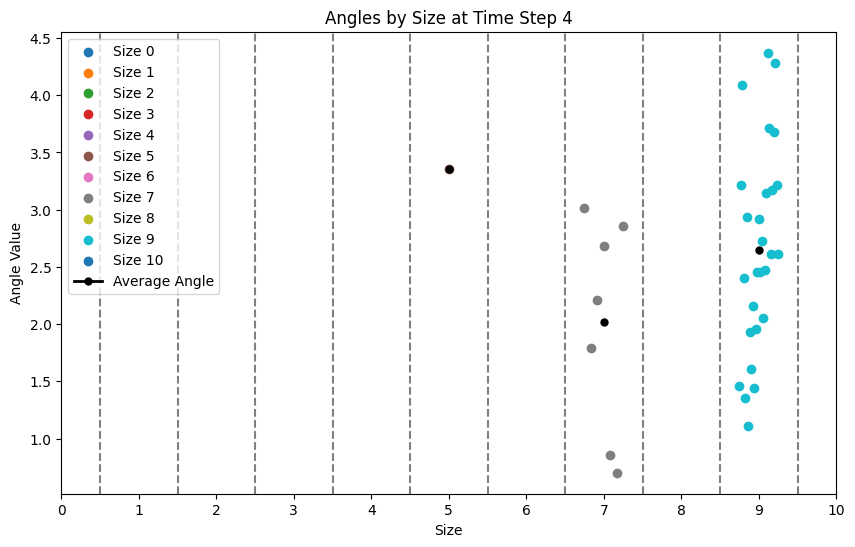

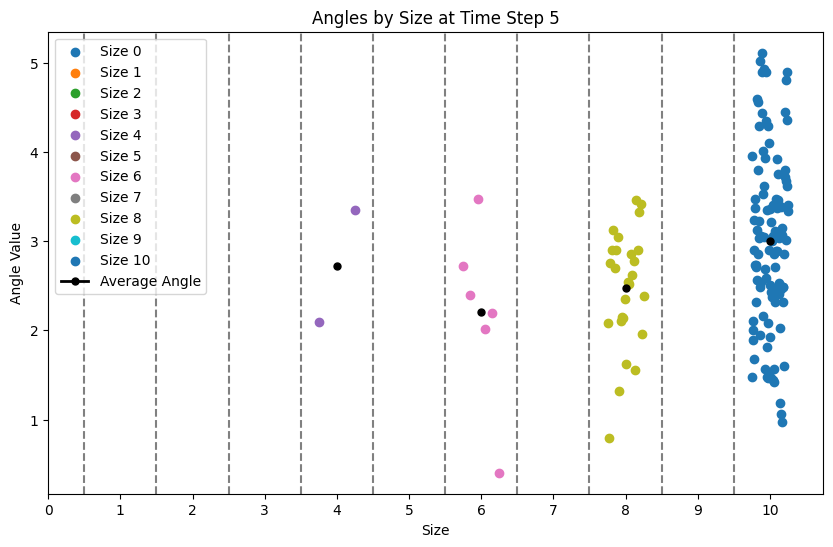

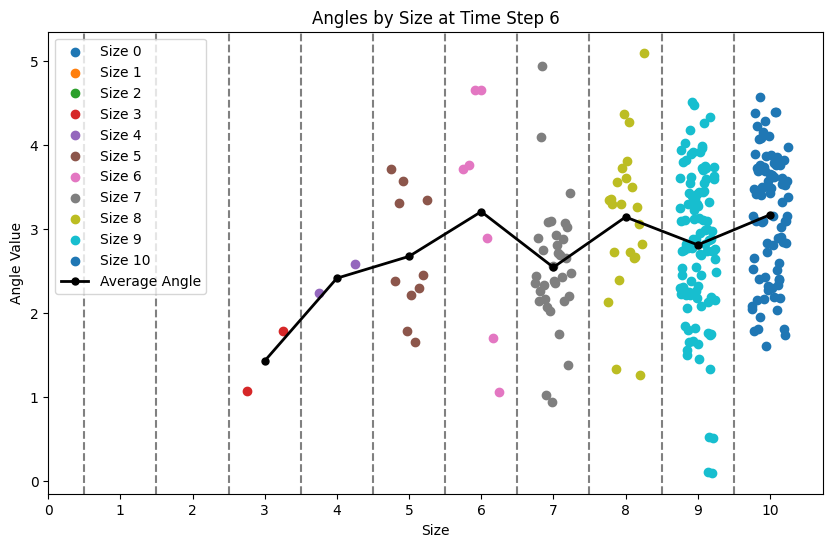

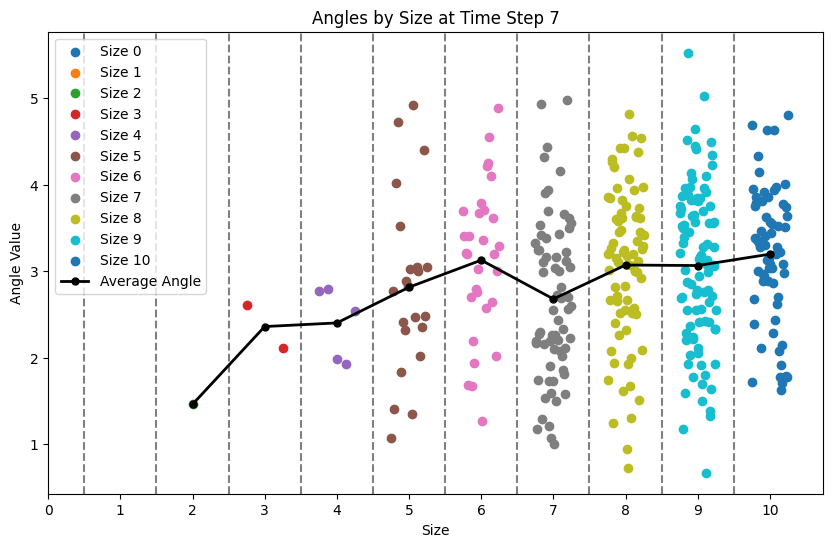

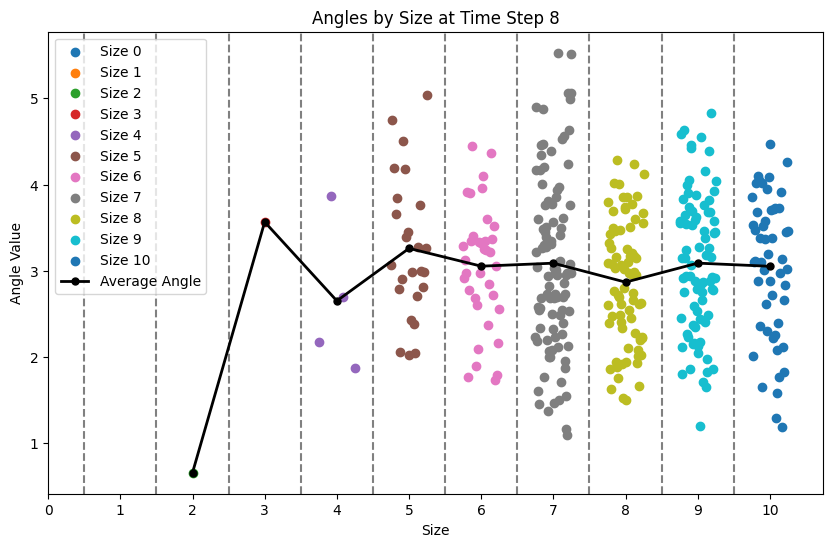

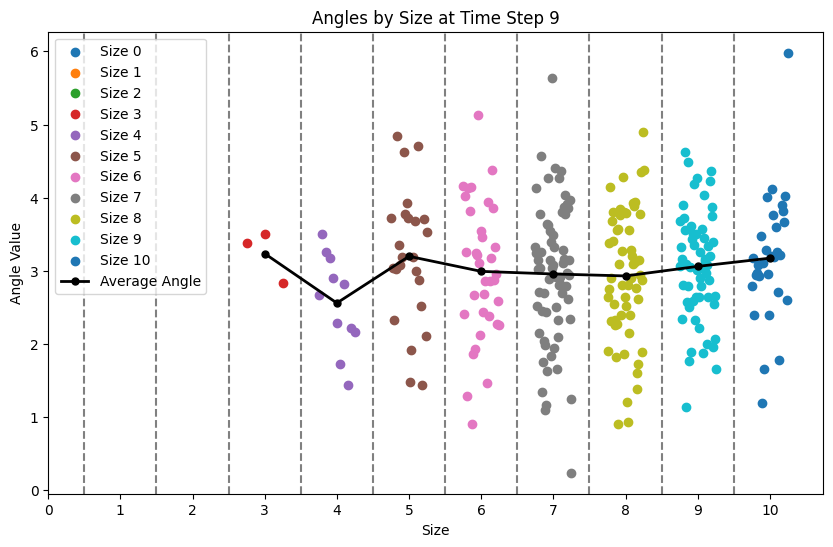

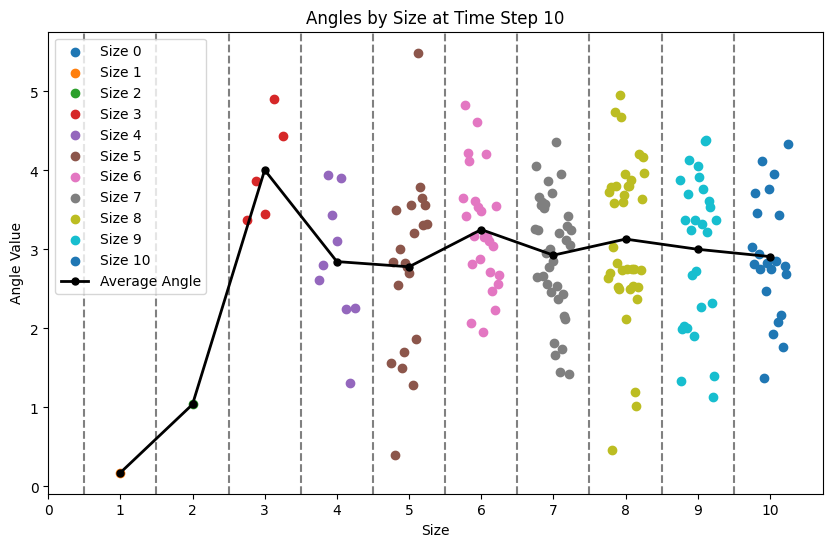

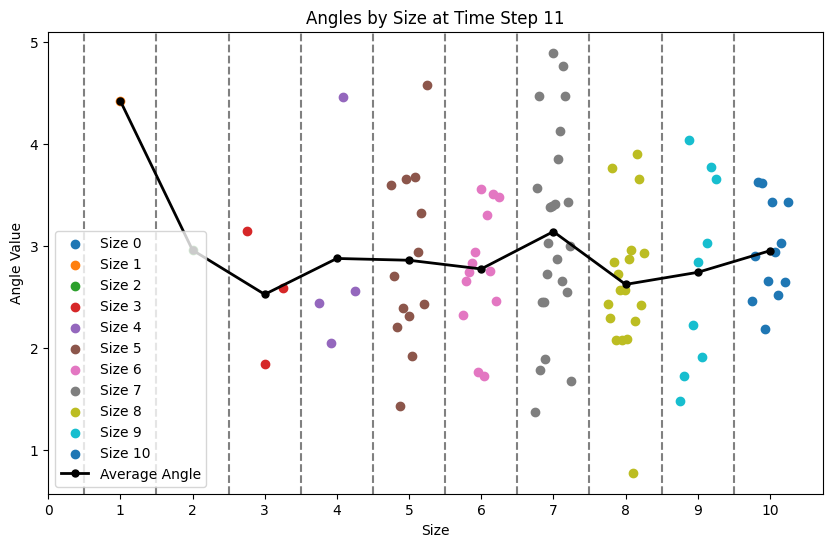

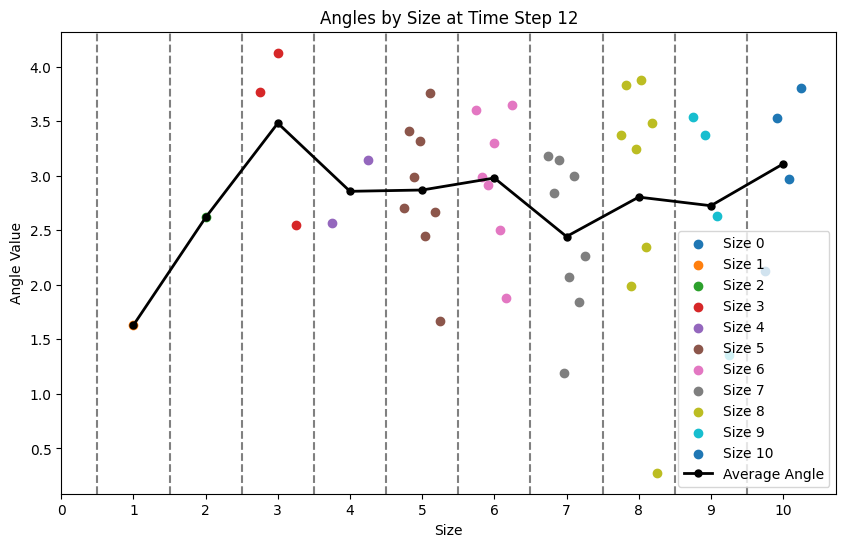

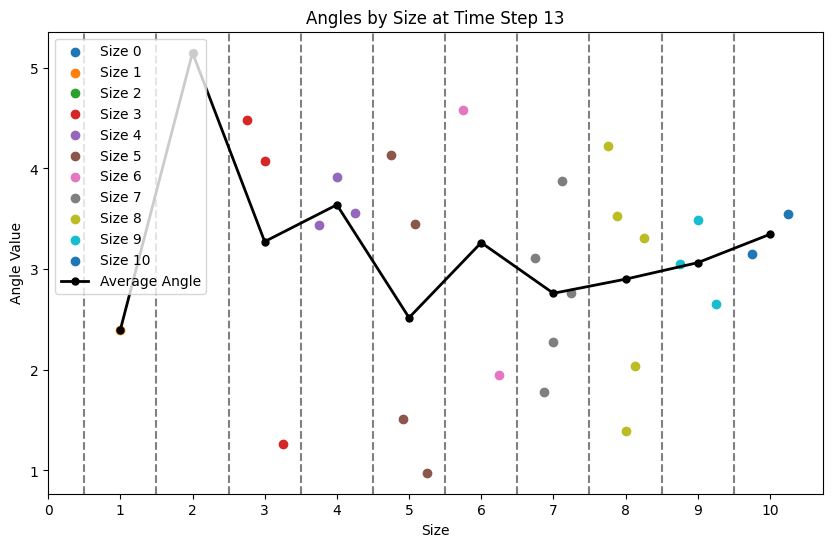

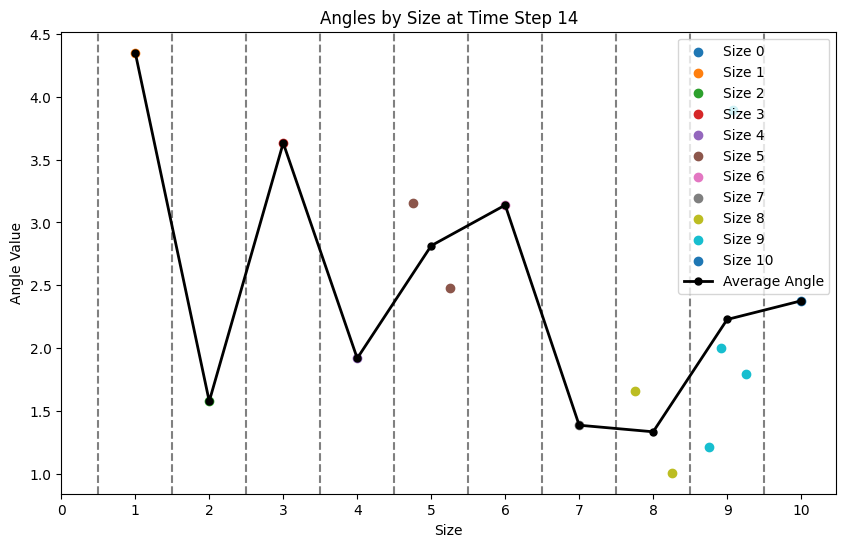

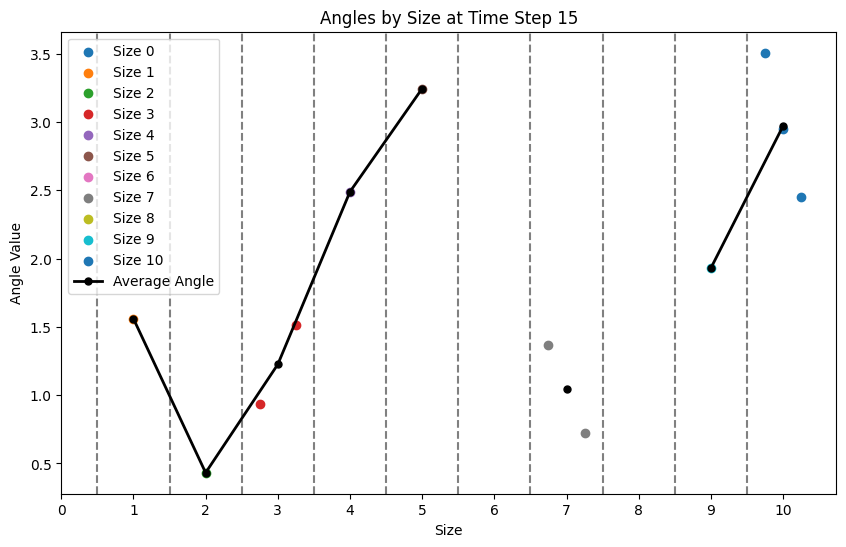

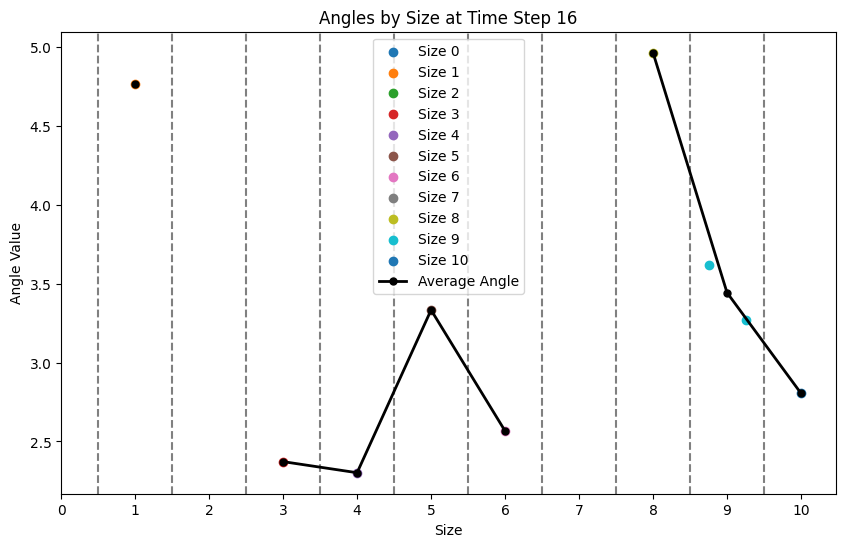

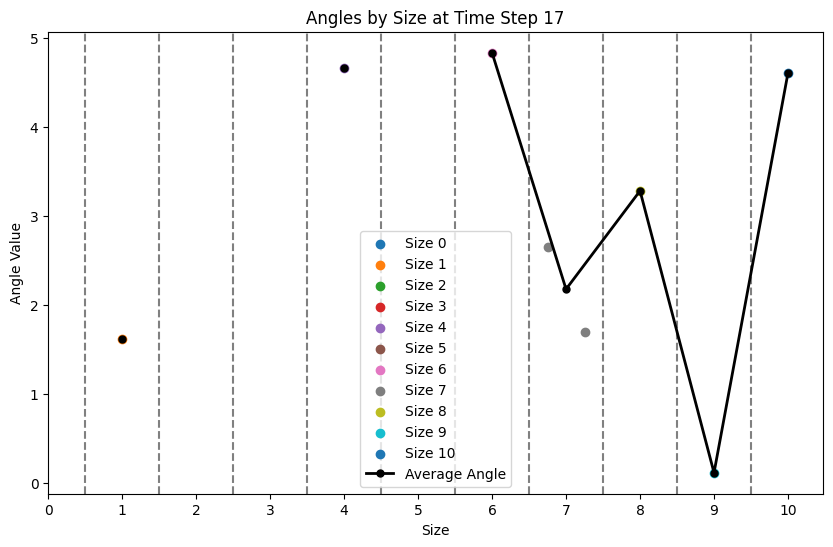

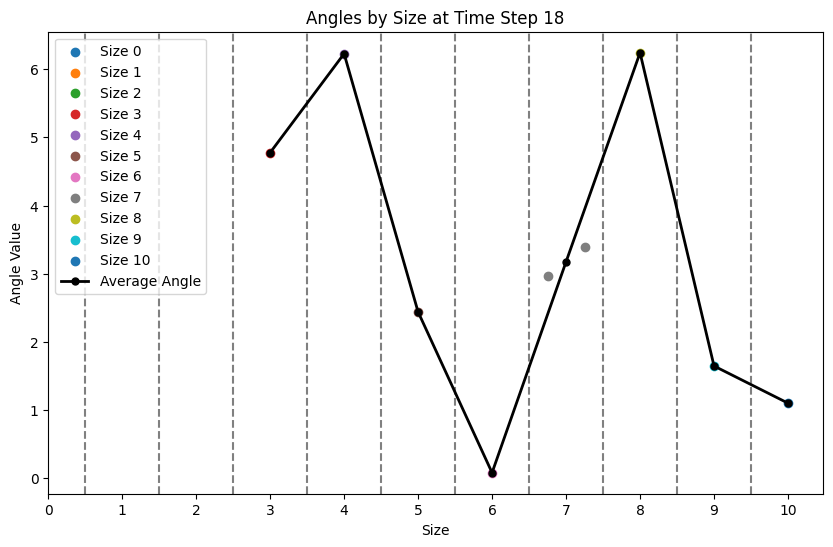

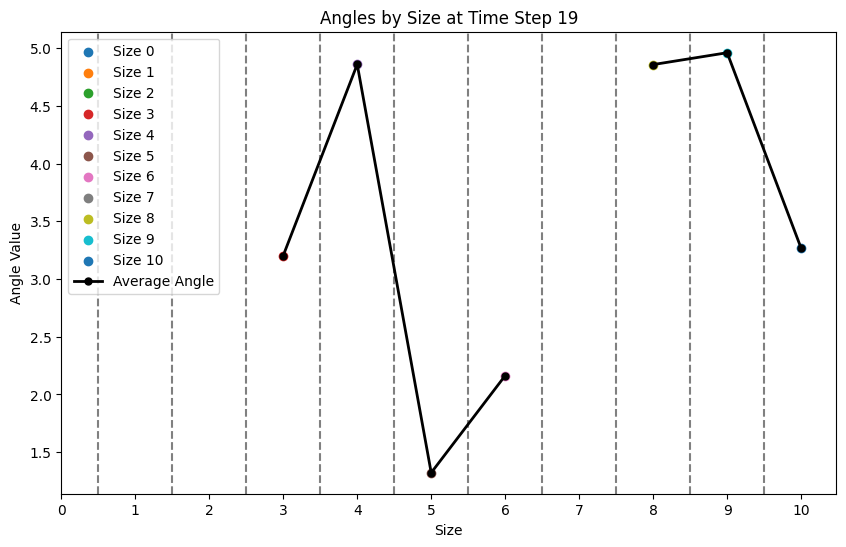

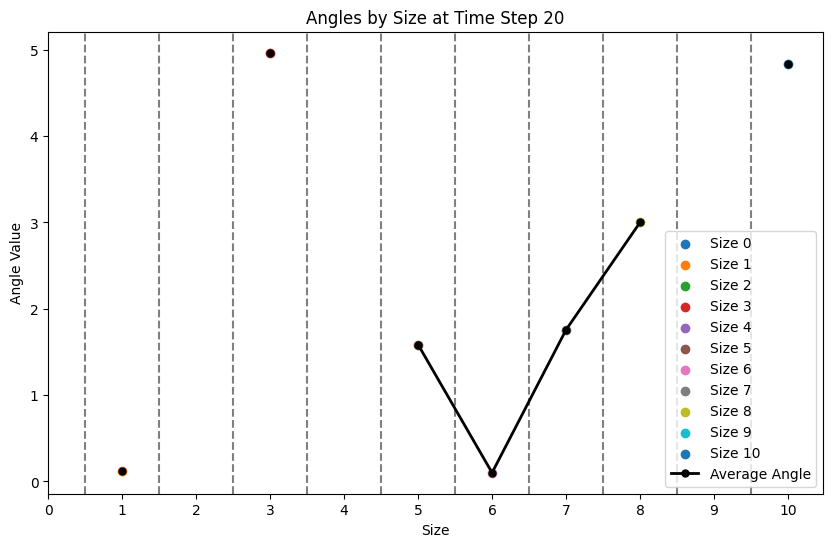

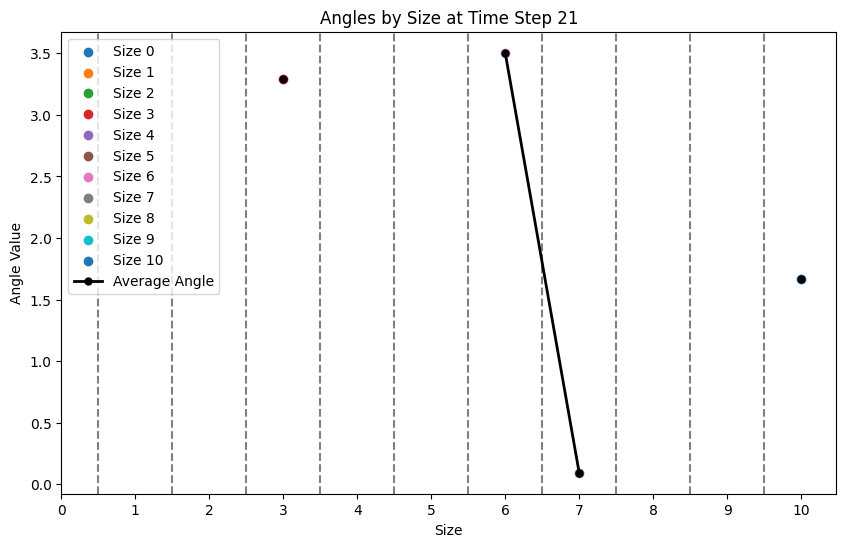

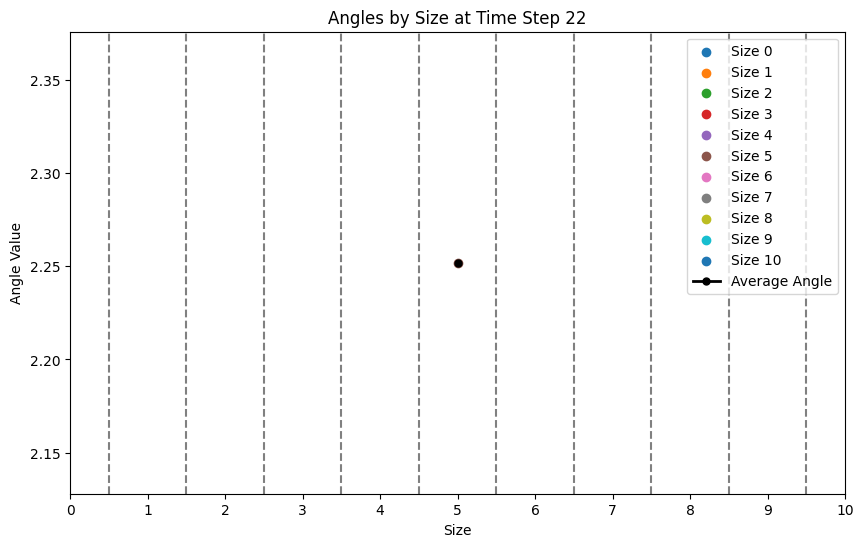

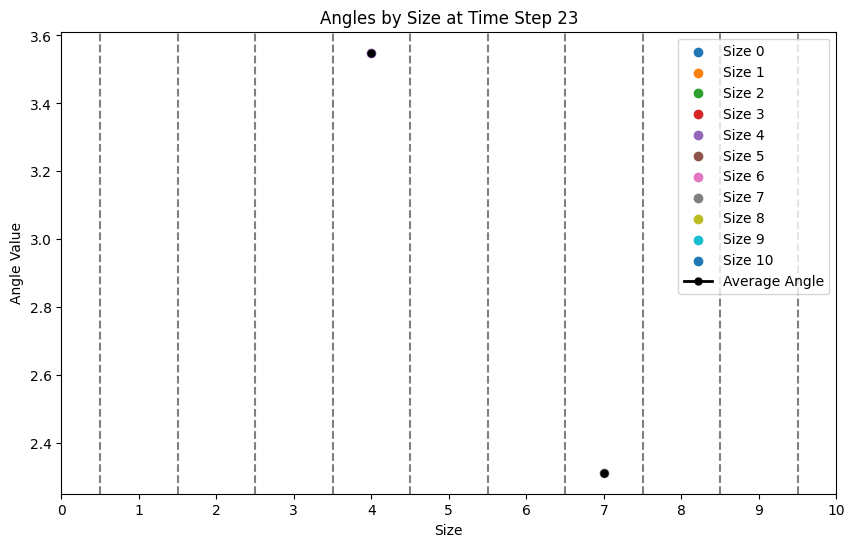

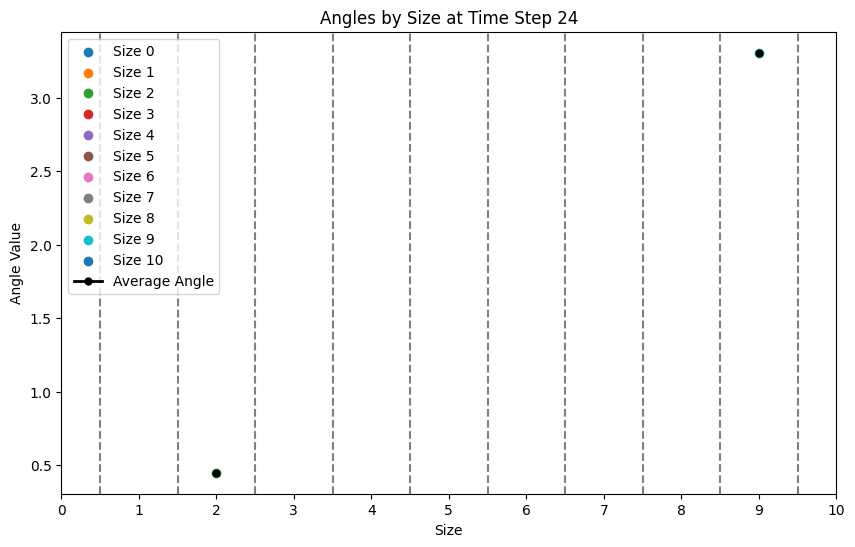

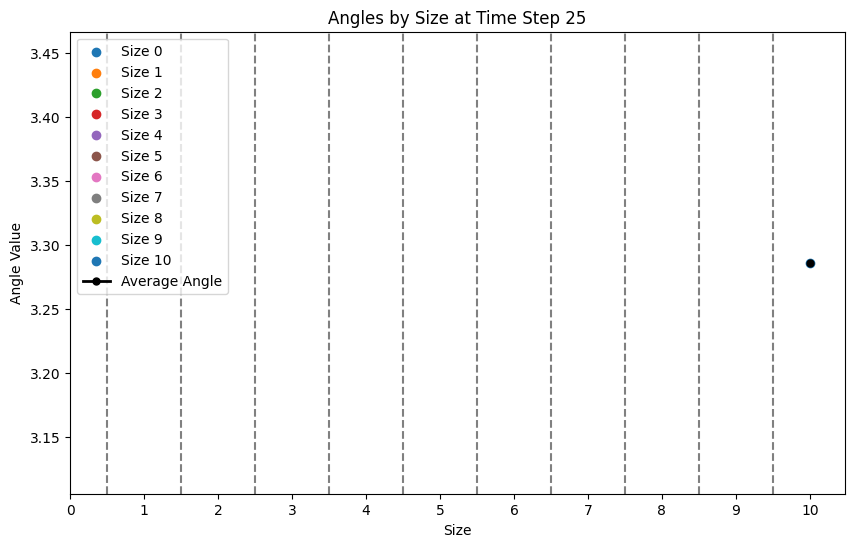

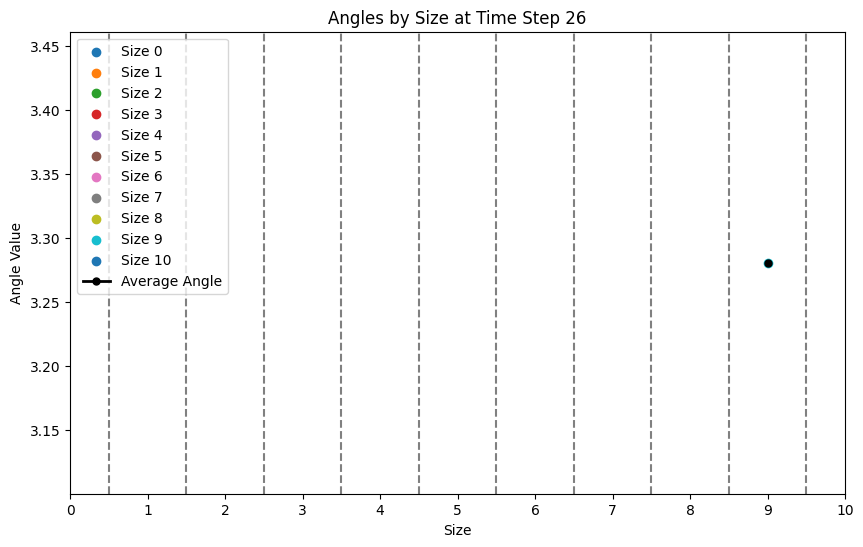

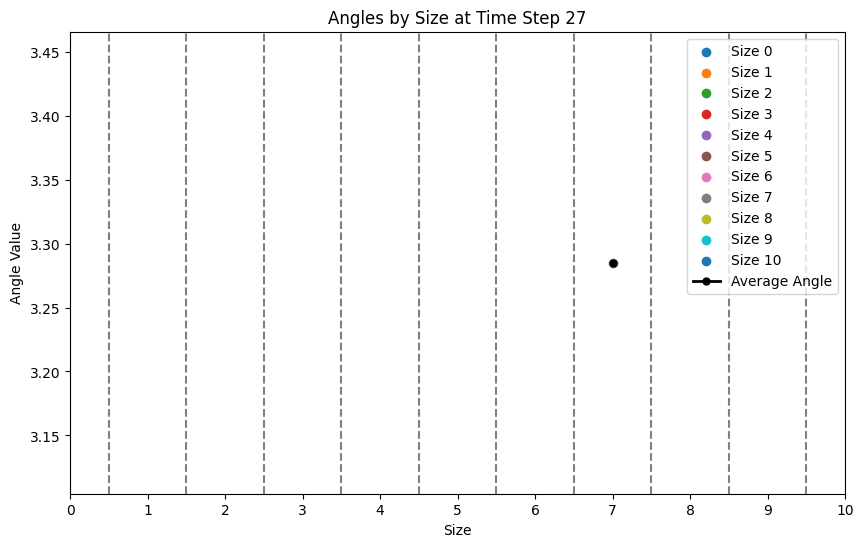

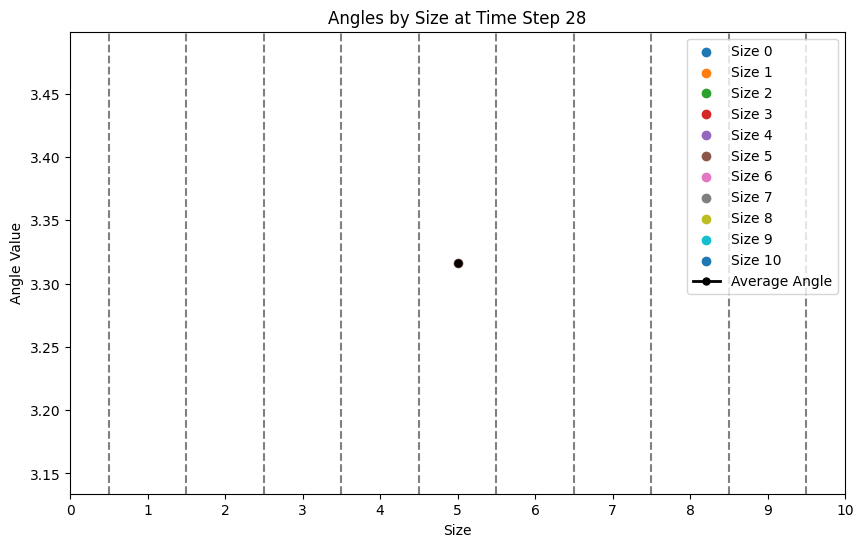

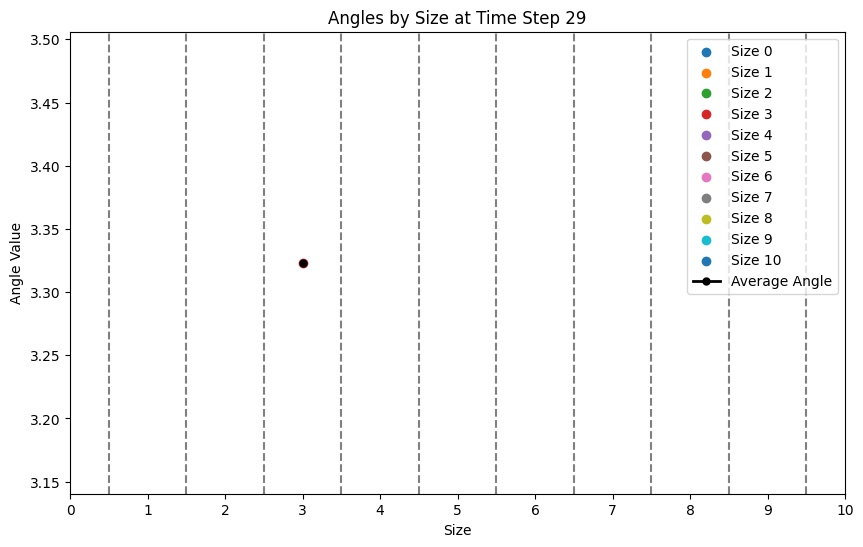

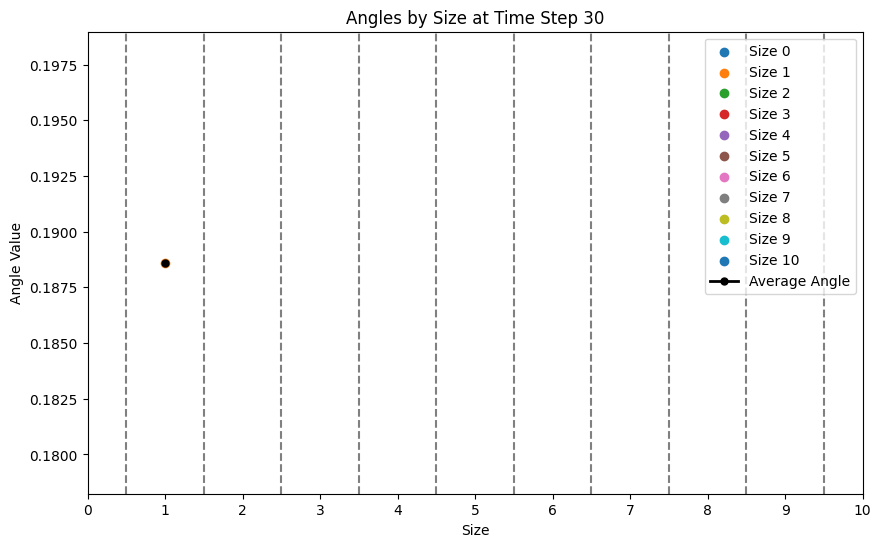

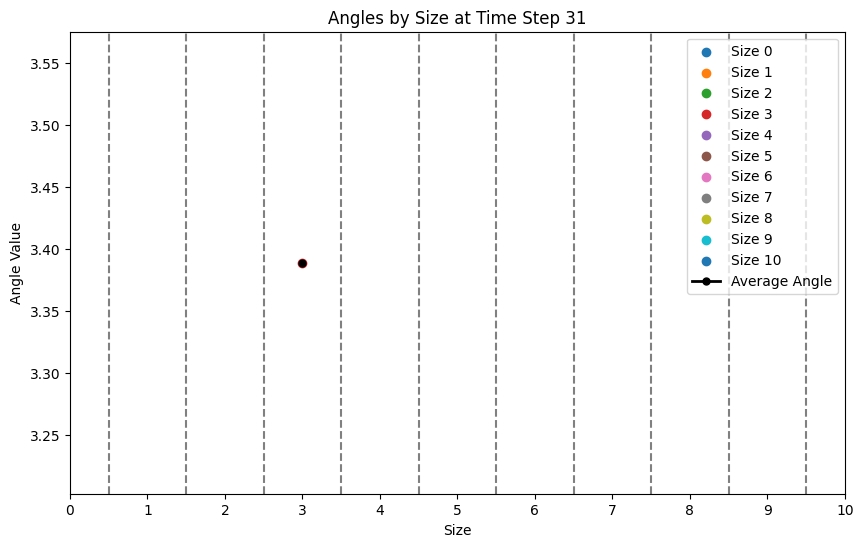

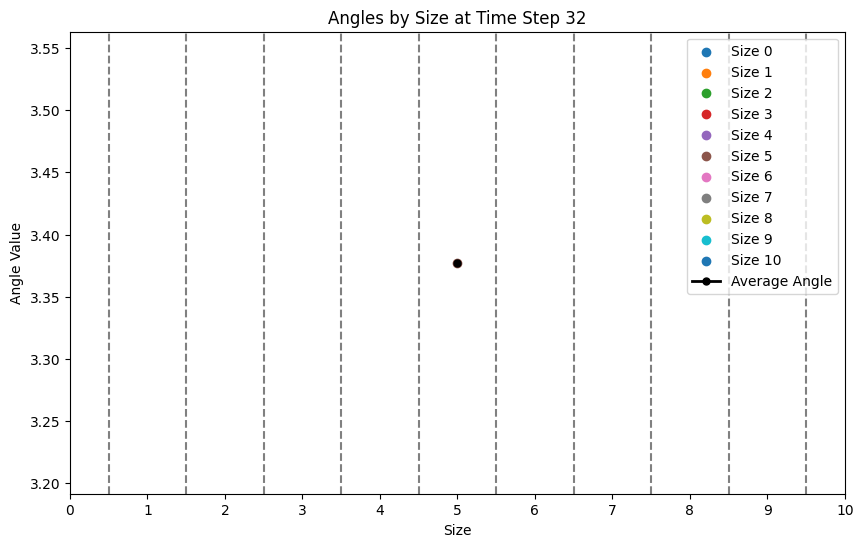

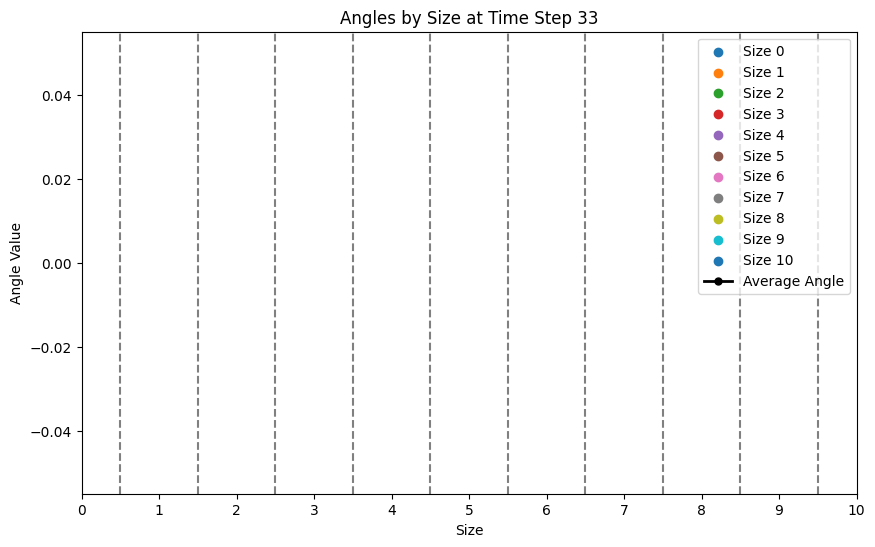

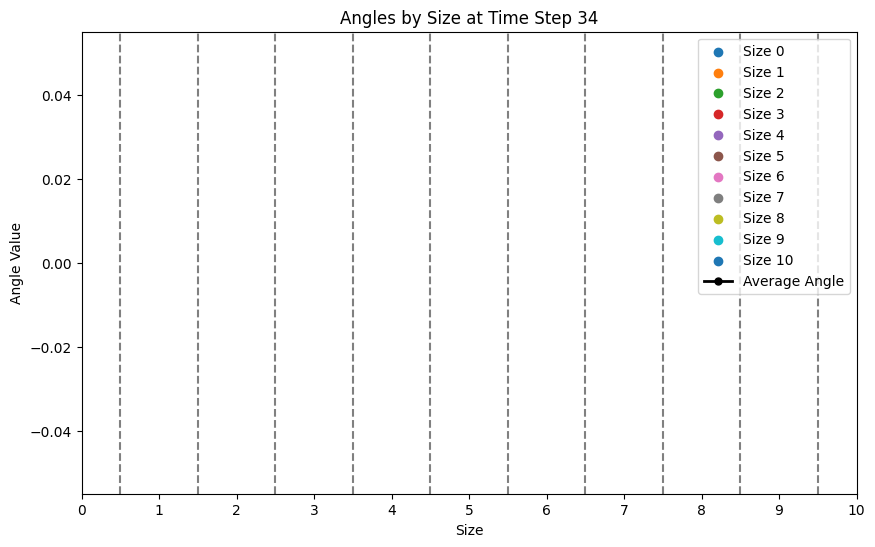

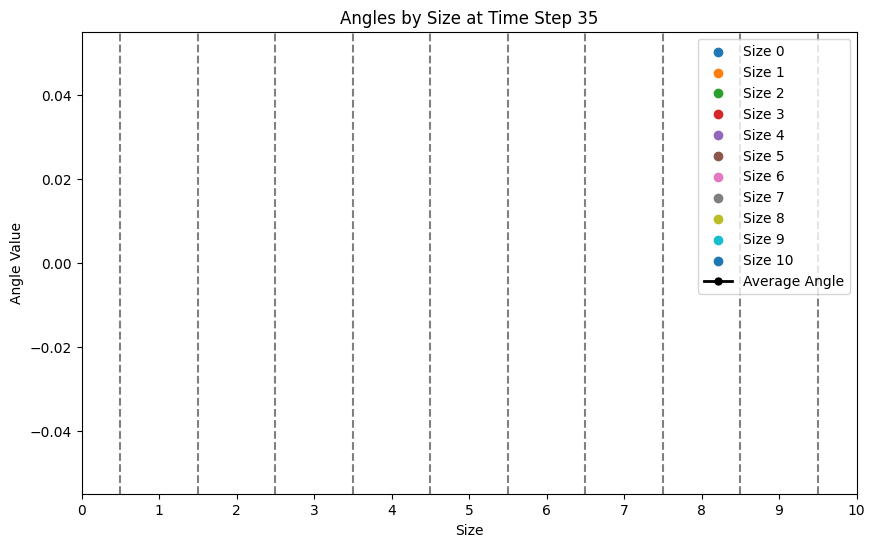

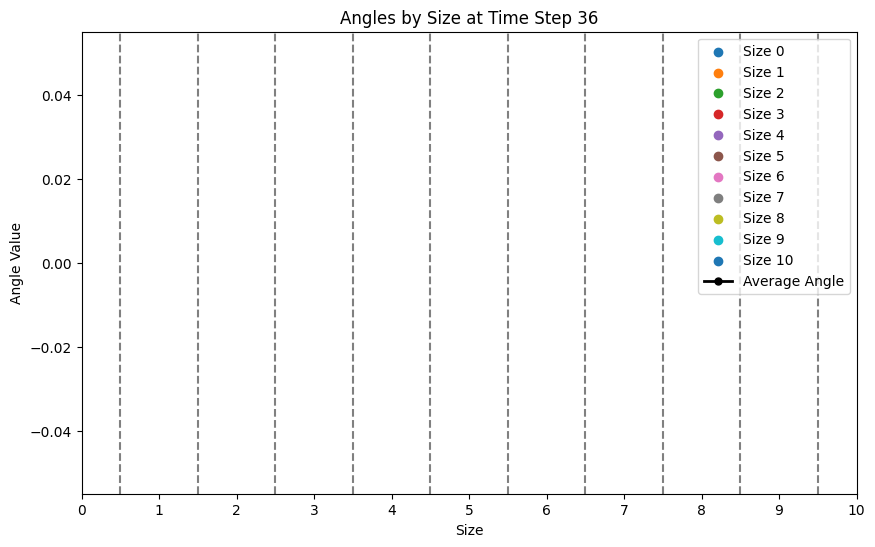

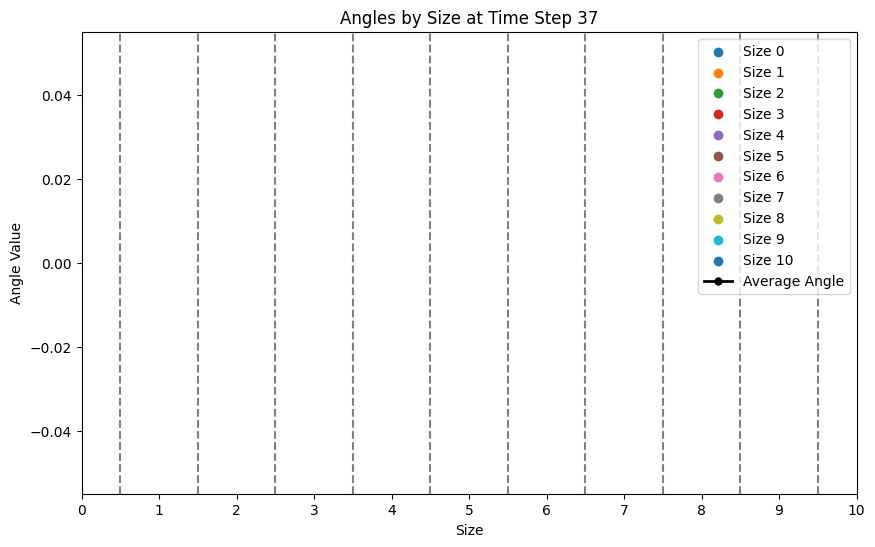

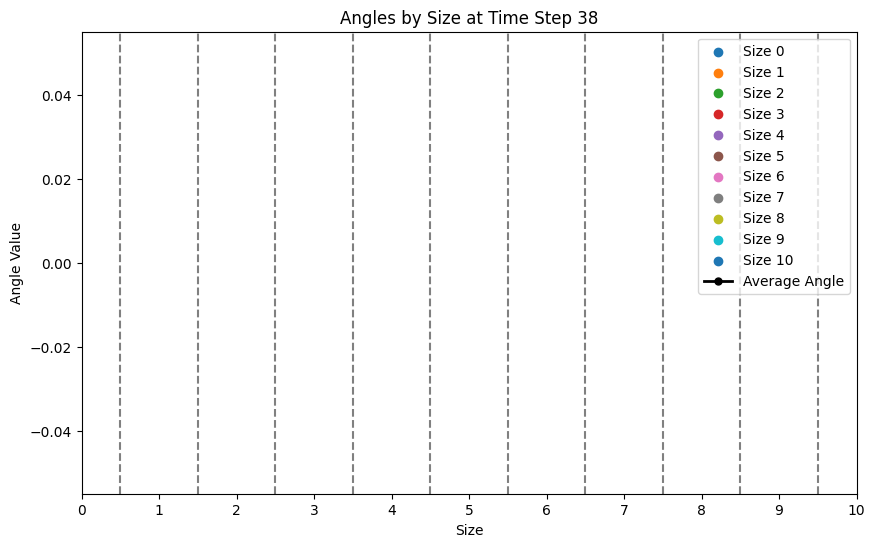

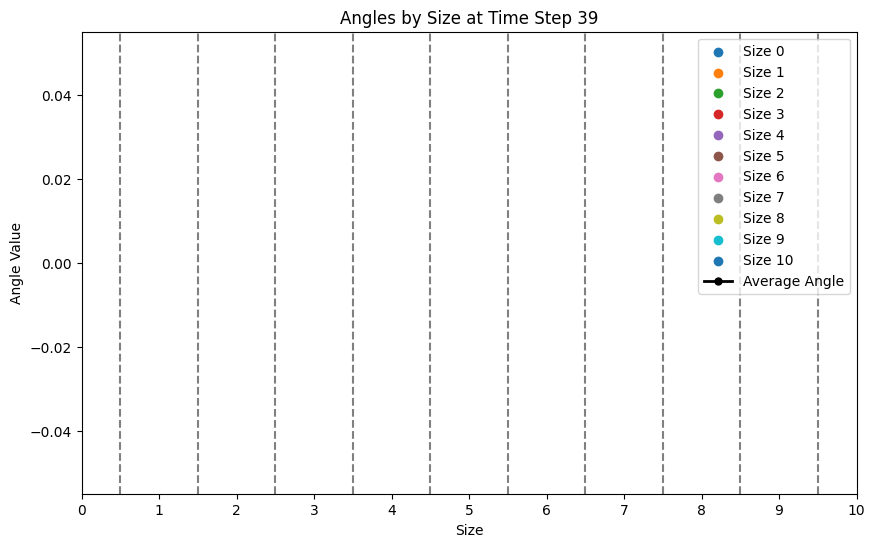

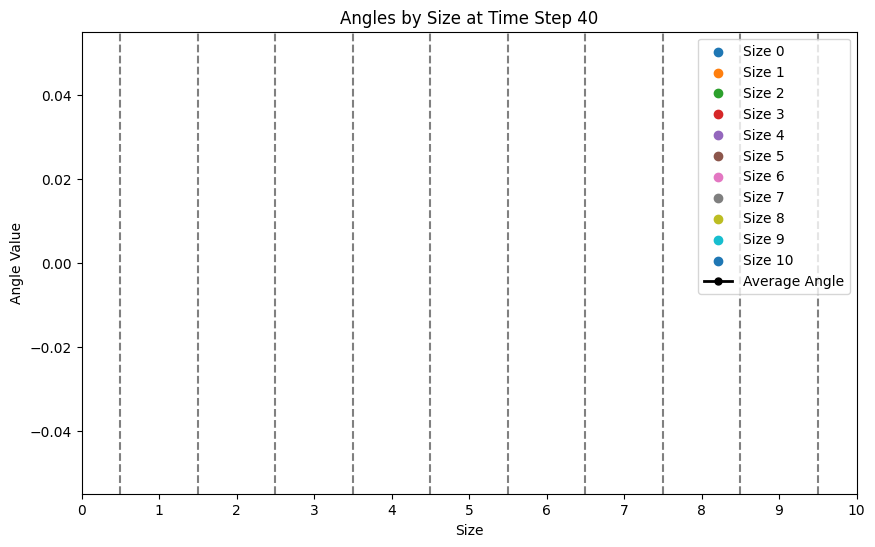

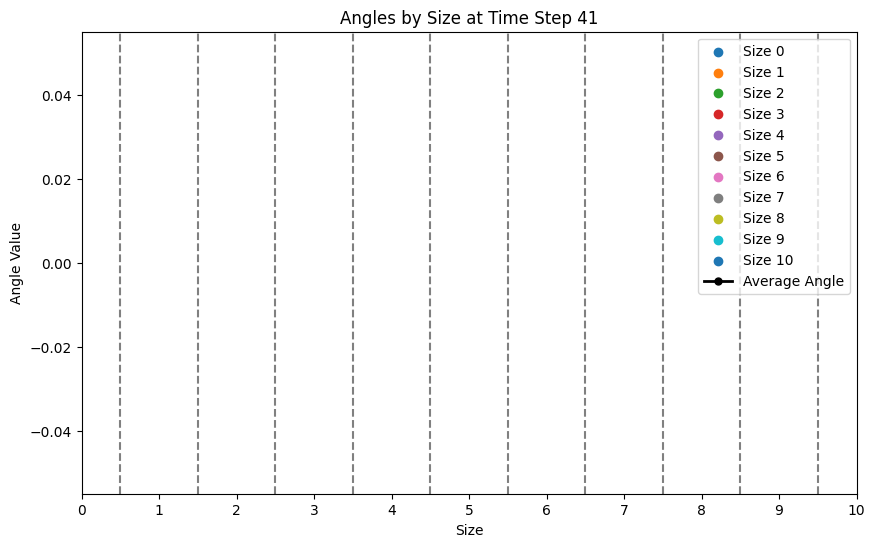

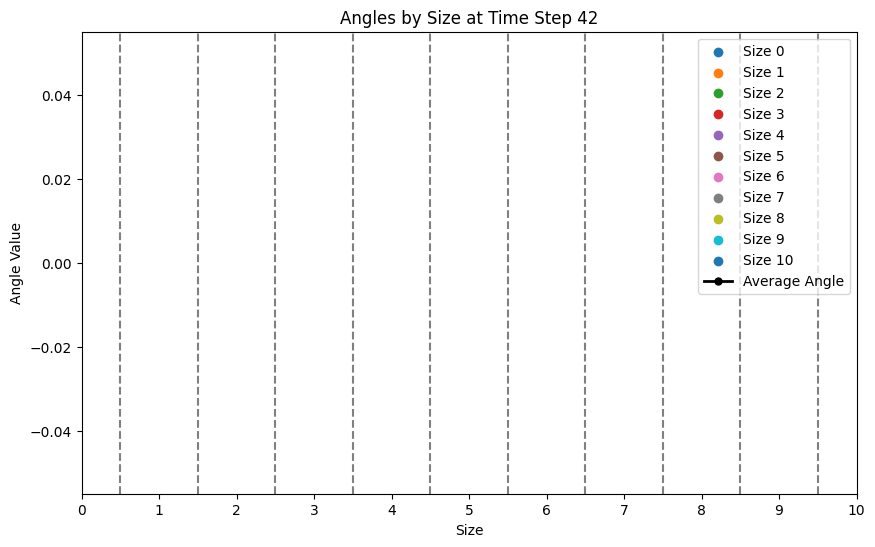

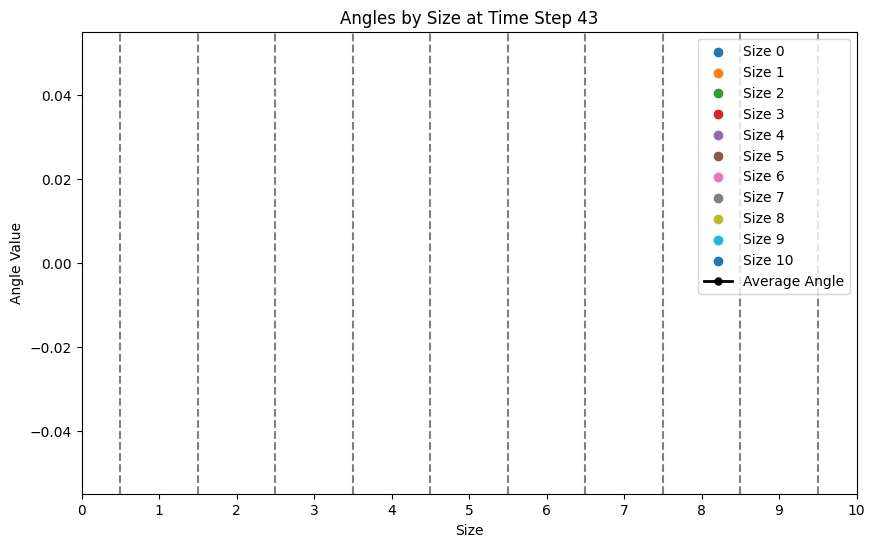

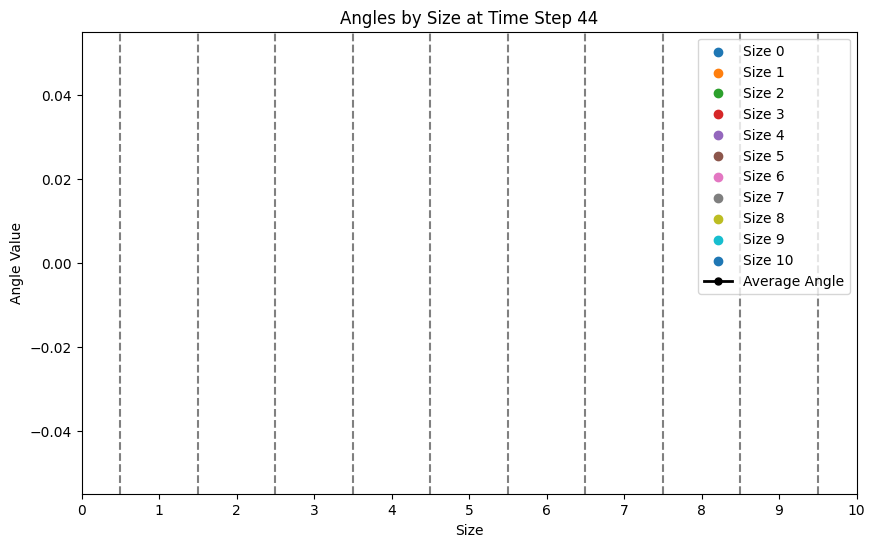

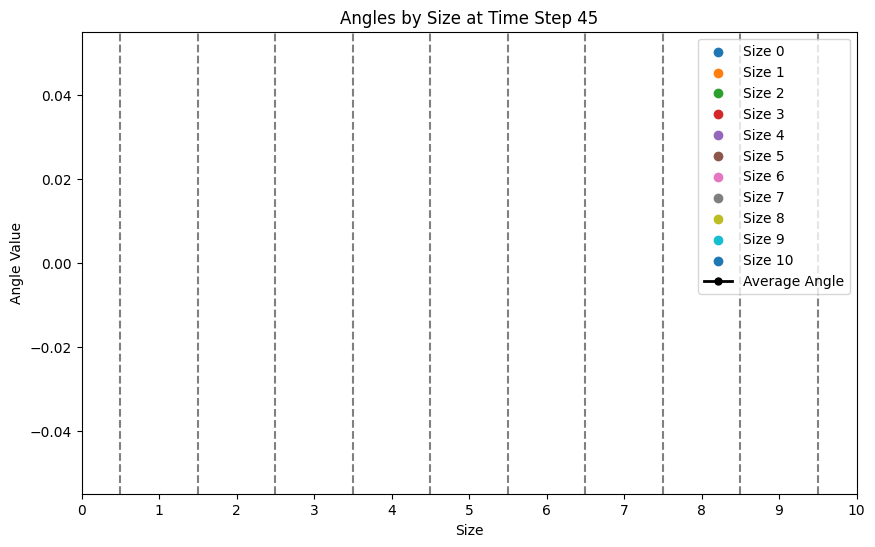

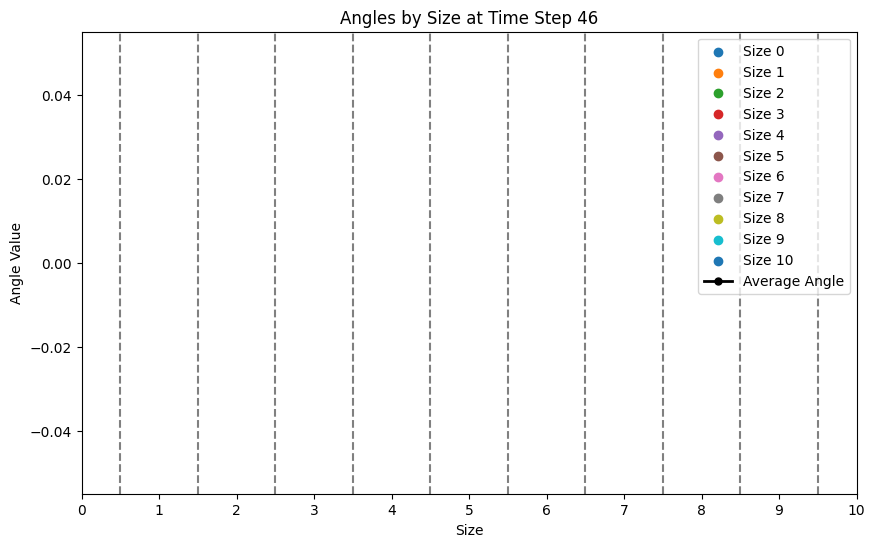

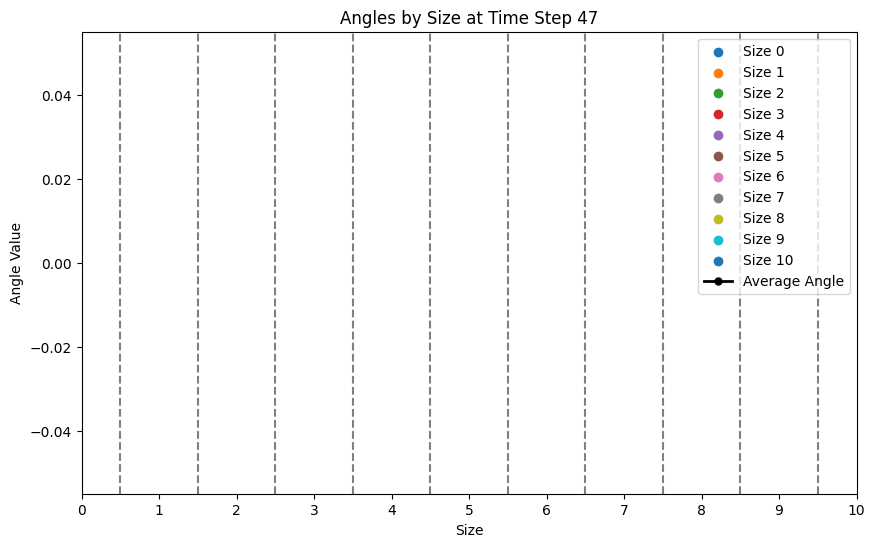

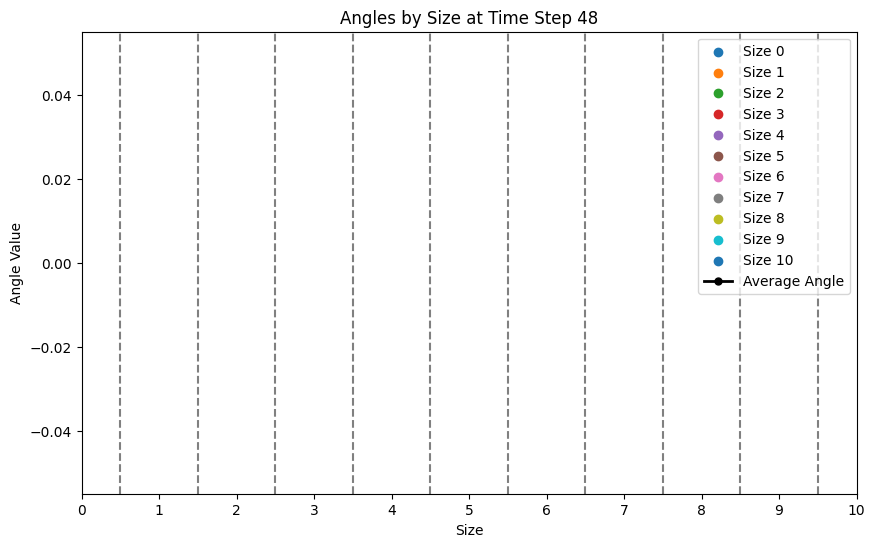

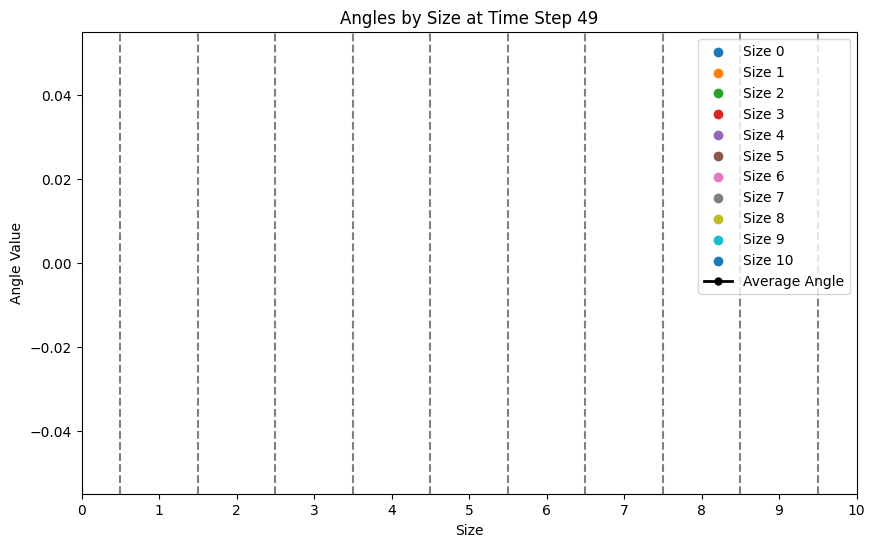

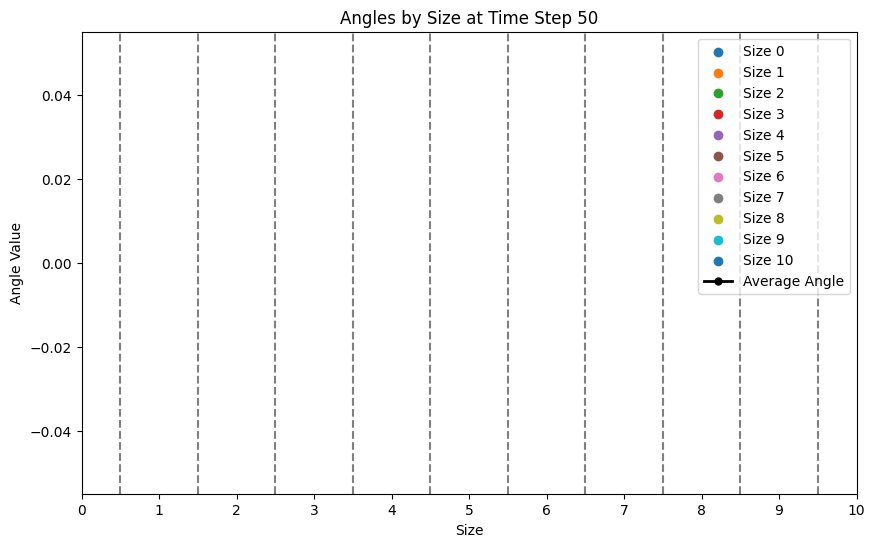

In [29]:
plots(time,Q, condition=True, coefs=q_i, paso=5)

### Ising trans N=12 h=0.2 V=IX

In [20]:
N=10
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])


time=30
q_i, q, Q = op_to_pauli_trans(time, V, N, b=np.pi/4, J=np.pi/4, h=0.2,paso=0.2)

0.0
0.2
0.4
0.6000000000000001
0.8
1.0
1.2000000000000002
1.4000000000000001
1.6
1.8
2.0
2.2
2.4000000000000004
2.6
2.8000000000000003
3.0
3.2
3.4000000000000004
3.6
3.8000000000000003
4.0
4.2
4.4
4.6000000000000005
4.800000000000001
5.0
5.2
5.4
5.6000000000000005
5.800000000000001
6.0
6.2
6.4
6.6000000000000005
6.800000000000001
7.0
7.2
7.4
7.6000000000000005
7.800000000000001
8.0
8.200000000000001
8.4
8.6
8.8
9.0
9.200000000000001
9.4
9.600000000000001
9.8
10.0
10.200000000000001
10.4
10.600000000000001
10.8
11.0
11.200000000000001
11.4
11.600000000000001
11.8
12.0
12.200000000000001
12.4
12.600000000000001
12.8
13.0
13.200000000000001
13.4
13.600000000000001
13.8
14.0
14.200000000000001
14.4
14.600000000000001
14.8
15.0
15.200000000000001
15.4
15.600000000000001
15.8
16.0
16.2
16.400000000000002
16.6
16.8
17.0
17.2
17.400000000000002
17.6
17.8
18.0
18.2
18.400000000000002
18.6
18.8
19.0
19.200000000000003
19.400000000000002
19.6
19.8
20.0
20.200000000000003
20.400000000000002
20.6
2

Time 0.0: 1.0
Time 0.2: 0.9999999995759989
Time 0.4: 0.9999999986687218
Time 0.6000000000000001: 0.9999999973263419
Time 0.8: 0.999999994222342
Time 1.0: 0.9999999878531463
Time 1.2000000000000002: 0.9999999796798812
Time 1.4000000000000001: 0.9999999654763932
Time 1.6: 0.9999999454385838
Time 1.8: 0.9999999044008333
Time 2.0: 0.9999998373823485
Time 2.2: 0.9999997436364805
Time 2.4000000000000004: 0.9999995815746751
Time 2.6: 0.9999993651488239
Time 2.8000000000000003: 0.9999990180919637
Time 3.0: 0.9999984853828163
Time 3.2: 0.9999977083354291
Time 3.4000000000000004: 0.9999966117888297
Time 3.6: 0.999995159365103
Time 3.8000000000000003: 0.9999934208913807
Time 4.0: 0.9999917304279834
Time 4.2: 0.9999903955655493
Time 4.4: 0.9999897638841506
Time 4.6000000000000005: 0.99999058957534
Time 4.800000000000001: 0.9999923891028863
Time 5.0: 0.9999942968896118
Time 5.2: 0.9999958785049212
Time 5.4: 0.9999970823300023
Time 5.6000000000000005: 0.9999979394189077
Time 5.800000000000001: 0.999

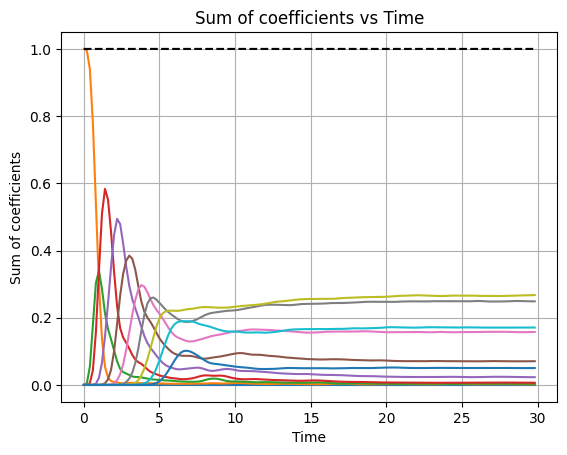

In [21]:
plots_trans(time,0.2,Q, condition=False, coefs=q_i, rebinning=5)

## h Bien (TFG)

In [25]:
N=8
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])
h=np.array([0.01044837, 0.05760976, 0.07093719, 0.15558772, 0.07337934, 0.00437979, 0.02806242, 0.11174344])


time=151
q_i0, q0, Q0,sizes0 = op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4), h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


Time 1: 1.0
Time 2: 1.0
Time 3: 0.9999999999999998
Time 4: 0.9999999998064052
Time 5: 0.9999999992521698
Time 6: 0.999999995897878
Time 7: 0.9999999750391872
Time 8: 0.9999998838157047
Time 9: 0.9999997988164304
Time 10: 0.999999663589932
Time 11: 0.9999996914022189
Time 12: 0.9999998136934393
Time 13: 0.999999905018016
Time 14: 0.9999999459604849
Time 15: 0.9999999629050105
Time 16: 0.999999968566009
Time 17: 0.9999999751365362
Time 18: 0.9999999805503004
Time 19: 0.9999999796145671
Time 20: 0.9999999833602343
Time 21: 0.9999999848135753
Time 22: 0.9999999867295779
Time 23: 0.9999999880202093
Time 24: 0.9999999879914192
Time 25: 0.9999999881995136
Time 26: 0.9999999879484058
Time 27: 0.9999999897595452
Time 28: 0.9999999897419489
Time 29: 0.9999999913046199
Time 30: 0.9999999909094129
Time 31: 0.9999999894699722
Time 32: 0.9999999906125108
Time 33: 0.9999999911200517
Time 34: 0.9999999913033895
Time 35: 0.9999999913589223
Time 36: 0.9999999905885328
Time 37: 0.9999999923987086
Time 38

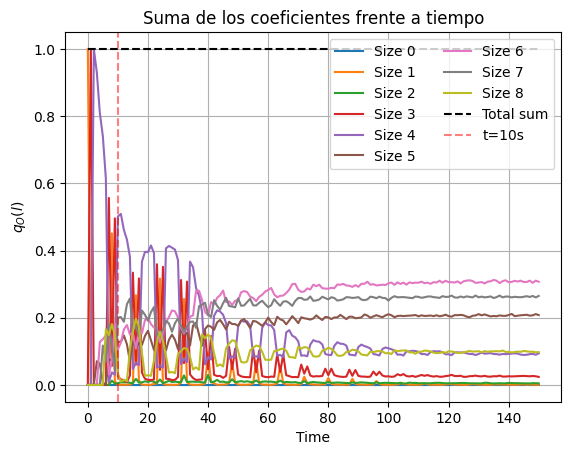

In [33]:
plots(time,Q, condition=False, coefs=q_i, paso=5)

In [107]:
h=np.array([0.01044837, 0.05760976, 0.07093719, 0.15558772, 0.07337934, 0.00437979, 0.02806242, 0.11174344])
N=8
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])


time=151
q_i, q, Q,sizess = op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4), h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


Time 1: 1.0
Time 2: 0.9999999999999999
Time 3: 1.0
Time 4: 0.999999999901577
Time 5: 0.9999999991817013
Time 6: 0.9999999942707511
Time 7: 0.9999999778251375
Time 8: 0.9999998943075377
Time 9: 0.9999997674918369
Time 10: 0.9999996241279371
Time 11: 0.9999995720067933
Time 12: 0.9999996541749857
Time 13: 0.9999997802103191
Time 14: 0.9999998644319456
Time 15: 0.999999903895716
Time 16: 0.999999928077293
Time 17: 0.99999994746002
Time 18: 0.9999999568290627
Time 19: 0.9999999644581643
Time 20: 0.9999999690995025
Time 21: 0.9999999748041296
Time 22: 0.9999999752444877
Time 23: 0.9999999790507673
Time 24: 0.999999979582953
Time 25: 0.9999999797883593
Time 26: 0.999999979938312
Time 27: 0.9999999836008484
Time 28: 0.9999999843266056
Time 29: 0.9999999839818127
Time 30: 0.9999999856033652
Time 31: 0.9999999866782957
Time 32: 0.9999999862317145
Time 33: 0.9999999875396052
Time 34: 0.9999999877490859
Time 35: 0.9999999883526063
Time 36: 0.9999999881372234
Time 37: 0.9999999904227307
Time 38: 0

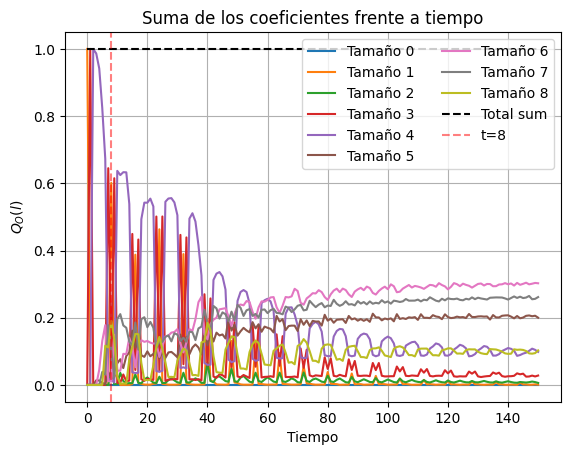

In [110]:
plots(time,Q, condition=False, coefs=q_i, paso=1)

In [64]:
h=np.array([0.01044837, 0.05760976, 0.07093719, 0.15558772, 0.07337934, 0.00437979, 0.02806242, 0.11174344])
N=8
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])

b = np.linspace((np.pi/4)-0.15, (np.pi/4), 15)

time=151
q_o=[]
Q_o=[]
q_io=[]
sizes_o=[]
for i,bp in enumerate(b):
    q_i1, q1, Q1,sizes1 = op_to_pauli(time, V, N, b=bp, J=(np.pi/4), h_random=h)
    q_o.append(q1)
    Q_o.append(Q1)
    q_io.append(q_i1)
    sizes_o.append(sizes1)
    # plots(time,Q1, condition=False, coefs=q_i1, paso=5)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
0
1
2
3
4
5


Time 1: 1.0
Time 2: 0.9999999999999988
Time 3: 0.999999999999998
Time 4: 0.9999999998948854
Time 5: 0.9999999995990352
Time 6: 0.9999999933798565
Time 7: 0.9999999537980271
Time 8: 0.999999835018827
Time 9: 0.9999999240899763
Time 10: 0.9999999651341673
Time 11: 0.99999998114095
Time 12: 0.9999999855274804
Time 13: 0.9999999885680105
Time 14: 0.9999999886613855
Time 15: 0.9999999905625526
Time 16: 0.9999999911753314
Time 17: 0.9999999910383737
Time 18: 0.9999999924203724
Time 19: 0.9999999937163585
Time 20: 0.9999999933365233
Time 21: 0.9999999935876198
Time 22: 0.9999999937043087
Time 23: 0.9999999945616759
Time 24: 0.999999993659693
Time 25: 0.9999999944049506
Time 26: 0.9999999944345095
Time 27: 0.9999999932625687
Time 28: 0.999999994981196
Time 29: 0.9999999938876329
Time 30: 0.999999995027051
Time 31: 0.9999999954422063
Time 32: 0.9999999947110633
Time 33: 0.9999999947214833
Time 34: 0.9999999951849954
Time 35: 0.9999999946533706
Time 36: 0.9999999935940628
Time 37: 0.999999995830

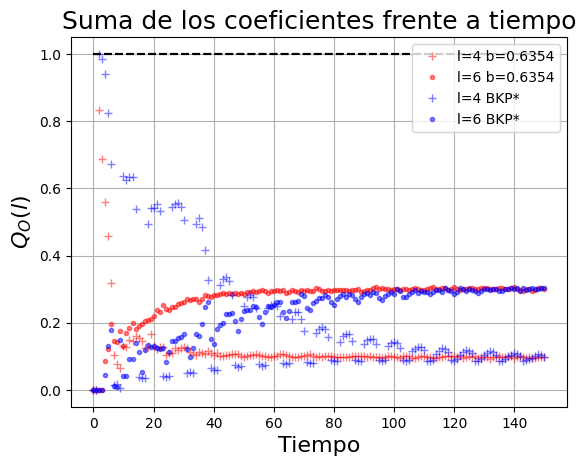

In [111]:
#plots
b = np.linspace((np.pi/4)-0.15, (np.pi/4), 15)
colors = plt.cm.magma(np.linspace(0, 1, 4))
colors=['red','green',  'blue']
q_o_select=[Q_o[0]]
b_select=[b[0],b[14]]
#Comprobamos que la suma de los coeficientes sea 1
plt.figure(2)

for i,qs in enumerate(q_o_select):

    q_mod_sum=[]
    for t in range(time):
        print(f'Time {t+1}: {sum(qs[t])}')
        q_mod_sum.append(sum(qs[t]))

    # Plot the sum of the coefficientsvs time
    
    
    q_temp1 = [qs[t][4] for t in range(time)]
    q_temp2 = [qs[t][6] for t in range(time)]
    
    plt.plot(range(time), q_temp1,'+',color=colors[i] ,label=f'l={4} b={np.round(b_select[i],4)}',alpha=0.5) #sum of the coefficients squared for each length
    plt.plot(range(time), q_temp2, '.',color=colors[i],label=f'l={6} b={np.round(b_select[i],4)}',alpha=0.5) #sum of the coefficients squared for each length
    plt.plot(range(time), q_mod_sum, 'k--')# Total sum 

  
q_temp1 = [Q[t][4] for t in range(time)]
q_temp2 = [Q[t][6] for t in range(time)]

plt.plot(range(time), q_temp1,'+',color=colors[-1] ,label=f'l={4} BKP*',alpha=0.5) #sum of the coefficients squared for each length
plt.plot(range(time), q_temp2, '.',color=colors[-1],label=f'l={6} BKP*',alpha=0.5) #sum of the coefficients squared for each length
plt.plot(range(time), q_mod_sum, 'k--')# Total sum 

# plt.axvline(x=8, color='red', linestyle='--',label='t=8',alpha=0.5)
plt.xlabel('Tiempo', fontsize=16)
plt.ylabel(r'$Q_O(l)$', fontsize=16)
plt.title('Suma de los coeficientes frente a tiempo', fontsize=18)
plt.legend(loc='upper right',ncol=1)
plt.grid(True)
plt.savefig(f'sizes fuera bkp 1 graf.pdf',dpi=400)
plt.show()

## Histogramas (TFG)

In [49]:
h=np.array([0.01044837, 0.05760976, 0.07093719, 0.15558772, 0.07337934, 0.00437979, 0.02806242, 0.11174344])
N=8
V = SparsePauliOp.from_list([('I' + 'X'+'I'*(N-2), 1)])


time=151    
q_i1, q1, Q1,sizess1= op_to_pauli(time, V, N, b=np.pi/4, J=(np.pi/4), h_random=h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150


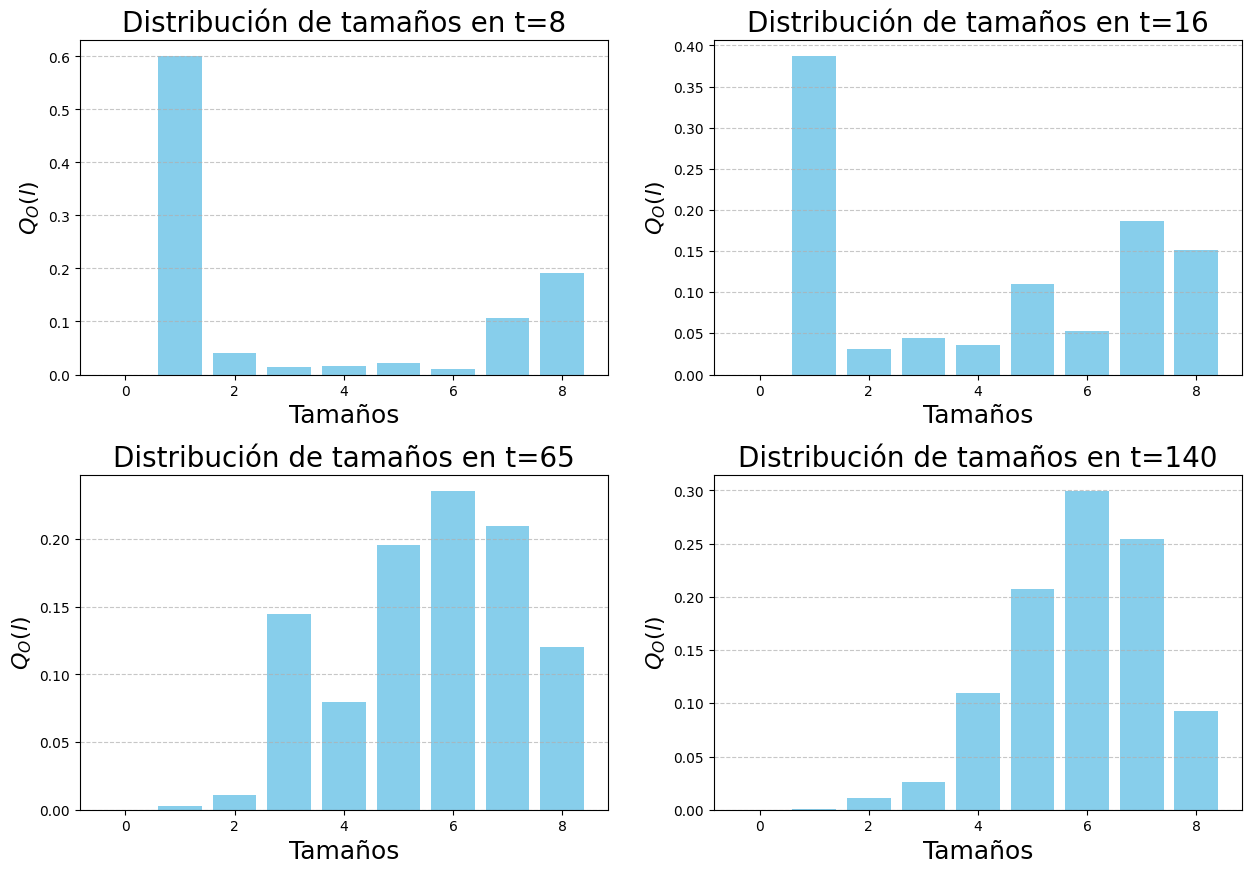

In [116]:
times=[8,16,65,140]

figi1=[0,0,1,1]
figi2=[0,1,0,1]

fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(15, 10))


for i,t in enumerate(times):

    
    ax[figi1[i],figi2[i]].bar(range(N+1), Q[t], color='skyblue', width=0.8)
    ax[figi1[i],figi2[i]].set_title('Distribución de tamaños en t=%g' % (t), fontsize=20)
    ax[figi1[i],figi2[i]].set_xlabel('Tamaños', fontsize=18)
    ax[figi1[i],figi2[i]].set_ylabel(r'$Q_O(l)$', fontsize=16)
    ax[figi1[i],figi2[i]].grid(axis='y', linestyle='--', alpha=0.7)

plt.subplots_adjust(hspace=0.3)

 
plt.savefig(f'histograma times={times}.pdf', dpi=600)  # Save the plot as PDF
plt.show()   

    